In [40]:
#import
import os
import sys

import tqdm
import math
import wandb
import torch
import pylab
import logging

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt

from random import randint
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

# Reading model and data

In [41]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [42]:
#params
project_name = "MSU_interpol"

logger_path = './wandb_local_logs'
data_path = '../data/clasdb_pi_plus_n.txt'

hyperparams_dict = {
    'scale_data': False,
    'test_size': 0.1,
    'batch_size': 32,
    'net_architecture': [5,60,80,100,120,140,240,340,440,640,2000,1040,640,340,240,140,100,80,60,20,1],
    'activation_function': nn.ReLU(),
    'loss_func': RMSELoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 2000,
    'es_min_delta': 0.00001,
    'es_patience': 20,
    'lr': 0.001,
    'lr_factor':0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

In [43]:
logger_full_path = os.path.join(logger_path, project_name, 'peachy-galaxy-32')

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

In [44]:
class InterpolDataSet(Dataset):
    def __init__(self, features, labels, weights):
        self.features = features
        self.labels = labels
        self.weights = weights
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        weights = self.weights[index]
        return feature, label, weights

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def setup(self, stage):
        # data reading and preprocessing
        df = pd.read_csv(data_path, delimiter='\t', header=None)
        df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df.loc[8314:65671, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        df['phi'] = df.phi.apply(lambda x: math.radians(x))
        df['weight'] = df['error'].apply(lambda x: x and 1 / x or 100) # x and 1 / x or 100  is just a reversed error but with validation 1/0 error in this case it will return 100
        df = df.drop('id', axis=1)
        df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        self.df = df


        #train test split
        feature_columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']
        feature_columns_with_weights = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'weight']

        feature_data = df[feature_columns_with_weights]
        label_data = df['dsigma_dOmega']

        if self.hyperparams.get('scale_data'):
            scaler_feature = StandardScaler()
            scaler_target = StandardScaler()
            feature_data = scaler_feature.fit_transform(feature_data)
            label_data = scaler_target.fit_transform(label_data.values.reshape(-1,1))
        else:
            pass

        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=1438)


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data[feature_columns].values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32),
                                             torch.tensor(train_feature_data['weight'].values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data[feature_columns].values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32),
                                           torch.tensor(val_feature_data['weight'].values, dtype=torch.float32))
    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y, w = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y, w)
        self.train_mae = self.mae(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y, w = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y, w)
        self.val_mae = self.mae(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }


In [8]:
data = InterpolDataModule(hyperparams_dict)
data.setup('test')
df = data.df
df_all = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
df_target = df[['dsigma_dOmega']]

model = InterpolRegressor.load_from_checkpoint(f'./wandb_local_logs/MSU_interpol/visionary-dew-39/checkpoints/exp_name=0val_loss=4.48010-epoch=87.ckpt', hyperparams=hyperparams_dict)
model.eval()
type(model)

2024-02-02 23:53:41,519 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol/visionary-dew-39/checkpoints/exp_name=0val_loss=4.48010-epoch=87.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


__main__.InterpolRegressor

In [9]:
preds = model.forward(torch.tensor(df_all.to_numpy(),dtype=torch.float32)).detach()
lables = torch.tensor(df_target.to_numpy(),dtype=torch.float32).reshape(-1,1)
loss = RMSELoss()
loss.forward(preds, lables)

tensor(0.3905)

# Checks

In [10]:
def interpol_check(df, number):
    example = df.iloc[number][['Ebeam', 'W', 'Q2', 'cos_theta']]
    
    df_example_set = df[(df.Ebeam == example['Ebeam'])&
                       (df.W == example['W'])&
                       (df.Q2 == example['Q2'])&
                       (df.cos_theta == example['cos_theta'])].sort_values('phi')
    
    df_example_set_for_prediction = pd.DataFrame({'Ebeam' : [example['Ebeam'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'W' : [example['W'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'Q2' : [example['Q2'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'cos_theta' : [example['cos_theta'] for _ in np.arange(0, 2*np.pi, 0.01)],
                                                  'phi' : [phi for phi in np.arange(0, 2*np.pi, 0.01)]})

#     return df_example_set
    with torch.no_grad():
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_example_set_for_prediction.to_numpy(),dtype=torch.float32)).detach()
     
    def func_cos(x, a, b, c): 
        return a + b*np.cos(2*x) + c*np.cos(x) 

    #input data 
    xdata = df_example_set.phi
    ydata = df_example_set.dsigma_dOmega 

    #fitting the data 
    popt, pcov = curve_fit(func_cos, xdata, ydata) 

    a, b, c = popt[0], popt[1], popt[2]
    #print the fitted parameters 
    print("a = %s , b = %s, c = %s" % (a, b, c))
    phi_theory = [i for i in np.arange(0, 2*np.pi, 0.01)]
    dsigma_dOmega_theory = [func_cos(x, a, b, c) for x in phi_theory]
    
    plt.figure(figsize=(22, 6), dpi=80)
    plt.plot(phi_theory, 
             dsigma_dOmega_theory, 
             label=f'fitted a + b*cos(2*x) + c*cos(x) function')
    plt.plot(df_example_set_for_prediction.phi, 
             dsigma_dOmega_predicted, 
             color='green', label=f'predicted')
    plt.scatter(x=df_example_set.phi, 
                y=df_example_set.dsigma_dOmega, 
                color='red', marker='*', label=f"real_data with params Ebeam: {example['Ebeam']}, W: {example['W']}, Q2: {example['Q2']}, cos_theta: {example['cos_theta']}")
    
    plt.xlabel("phi: rad")
    plt.ylabel("dsigma_dOmega: barn")
    
    plt.legend()
    plt.show()

a = 1.6953249999999997 , b = -0.07247393000396193, c = -0.07519001723241277


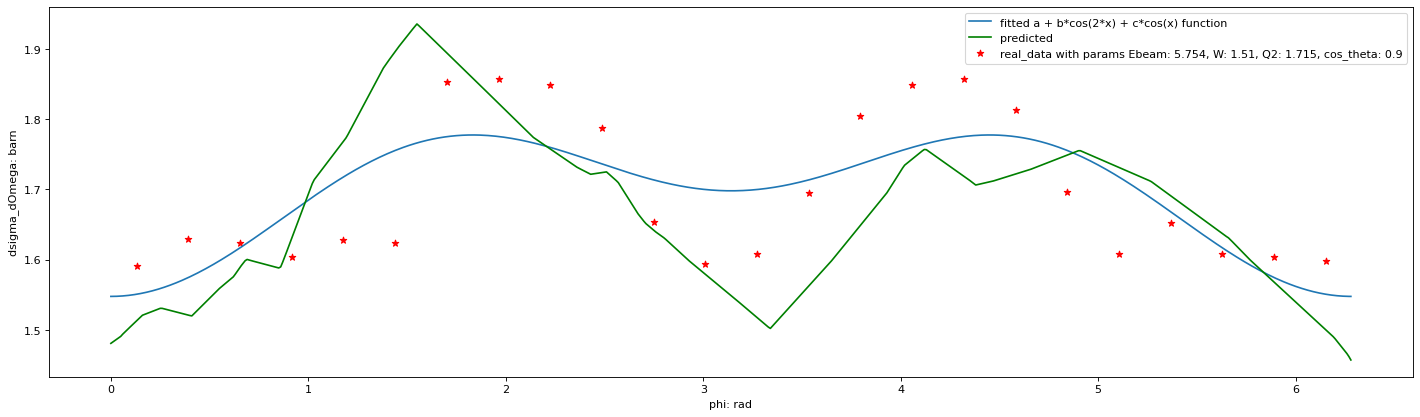

In [29]:
interpol_check(df, randint(0, len(df)))

In [30]:
def integral_cross_section_W_Q2():
    rand_n = randint(0, len(df))
    grid_step_phi = 0.001
    grid_step_q2 = 0.5

    example = df.iloc[rand_n]
    df_example_set = df[(df.Ebeam == example['Ebeam'])&
                       (df.cos_theta == example['cos_theta'])].sort_values('phi')

    phi_grid = np.arange(0, 2*np.pi, grid_step_phi)
    W_grid = np.sort(df_example_set.W.unique())
    Q2_grid = np.arange(df_example_set.Q2.min(), df_example_set.Q2.max(), grid_step_q2)



    final_list = []

    for j in range(len(Q2_grid)):
        for i in range(len(W_grid)):
            one_set = pd.DataFrame({'Ebeam' : [example['Ebeam'] for _ in range(len(phi_grid))],
                                     'W' :  [W_grid[i] for _ in range(len(phi_grid))],
                                     'Q2' : [Q2_grid[j] for _ in range(len(phi_grid))],
                                     'cos_theta' : [example['cos_theta'] for _ in range(len(phi_grid))],
                                     'phi' : phi_grid})
            
            
            one_predictions_set = model.forward(torch.tensor(one_set.to_numpy(),dtype=torch.float32)).detach()

            final_list.append({'Ebeam' : example['Ebeam'],
                                'W' :  W_grid[i],
                                'Q2' : Q2_grid[j],
                                'cos_theta' : example['cos_theta'],
                                'phi' : 'all_phi',
                                'dsigma_dOmega' : np.trapz(one_predictions_set.flatten(), dx=grid_step_phi)})

        cross_sections_int = [element['dsigma_dOmega'] for element in final_list]


    df_final_list = pd.DataFrame(final_list)

    plt.figure(figsize=(22, 6), dpi=80)
    for j in range(len(Q2_grid)):
        plt.scatter(x=W_grid, 
                    y=df_final_list[df_final_list.Q2 == Q2_grid[j]]['dsigma_dOmega'], 
                    marker='*', label=f"Predicted integral cross_section. Fixed params: Ebeam {example['Ebeam']}, Q2: {np.round(Q2_grid[j],2)}, cos_theta: {example['cos_theta']}")

    plt.xlabel("W: GeV")
    plt.ylabel("dsigma_dOmega: barn")

    plt.legend()
    plt.show()

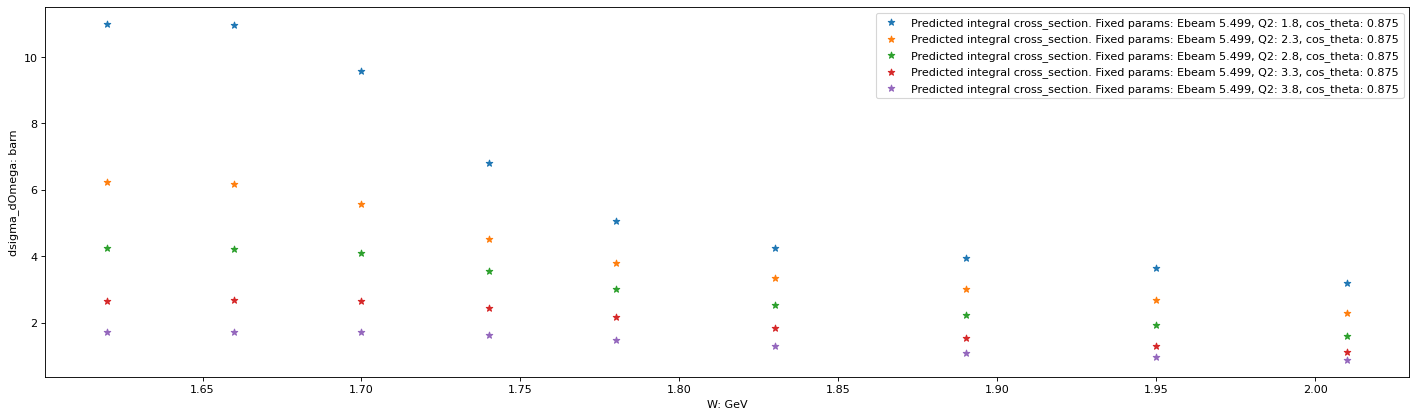

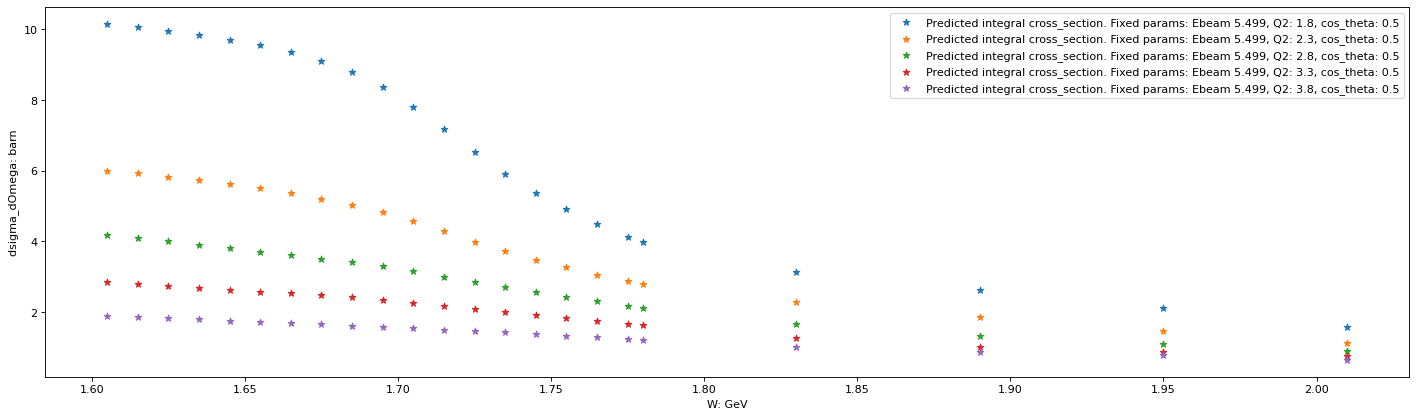

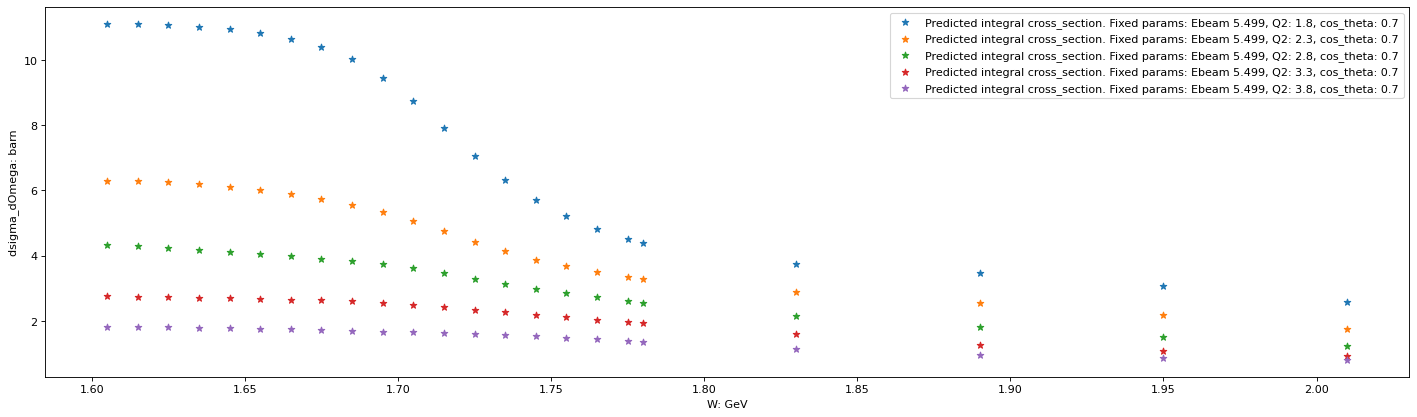

KeyboardInterrupt: 

In [42]:
for _ in range(30):
    integral_cross_section_W_Q2()

# Structure functions

In [32]:
# df_grid
Ebeam = 5.754
step_W = 0.005
step_Q2 = 0.1
step_cos_theta = 0.1
step_phi = 0.05


data_grid = []
for W in tqdm.tqdm(np.arange(1.1, 2.2 + step_W, step_W)):
    for Q2 in np.arange(1.6, 4.3 + step_Q2, step_Q2):
         for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,
                                      W,
                                      Q2,
                                      cos_theta, 
                                      phi])
                    
df_grid = pd.DataFrame(data_grid)
df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']


df_grid.W = np.round(df_grid.W, 3)
df_grid.Q2 = np.round(df_grid.Q2, 3)
df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
df_grid.phi = np.round(df_grid.phi, 3)

100%|██████████| 221/221 [00:18<00:00, 12.26it/s]


In [33]:
df_grid_parts = np.array_split(df_grid, 100)
df_grid_parts_preds = []
for df_grid_part in tqdm.tqdm(df_grid_parts):
    dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

    df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
    df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)

    df_grid_part['A'] = 0
    df_grid_part['B'] = 0
    df_grid_part['C'] = 0
    df_grid_parts_preds.append(df_grid_part)

/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 100/100 [30:59<00:00, 18.59s/it]


In [34]:
df_grid = pd.concat(df_grid_parts_preds)

In [35]:
phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

In [36]:
for i in tqdm.tqdm(range(len(phi_min_index))):
    cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
    cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
    cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
    
    trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
    trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
    trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)
    
    A = trapz_A/(2*np.pi)
    B = trapz_B/(np.pi)
    C = trapz_C/(np.pi)
    
    df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
    df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
    df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

  0%|          | 0/129948 [00:00<?, ?it/s]/var/folders/xz/1q44kbwx25g7j6b7qsjs_x4r0000gp/T/ipykernel_33500/8065968.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2958410871898921' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
/var/folders/xz/1q44kbwx25g7j6b7qsjs_x4r0000gp/T/ipykernel_33500/8065968.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.1478106619059221' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
/var/folders/xz/1q44kbwx25g7j6b7qsjs_x4r0000gp/T/ipykernel_33500/8065968.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '

##### Almaz data

In [37]:
df_a = pd.read_csv('../data/final_table.csv', header=None, sep='\t',
                    names=['Channel', 'MID', 'Wmin', 'Wmax', 'Q2min', 'Q2max', 'Cos(theta)', 'sigma_t', 'd_sigma_t',
                    'sigma_l', 'd_sigma_l', 'sigma_tt', 'd_sigma_tt', 'sigma_lt', 'd_sigma_lt', 'eps'])
df_a = df_a[df_a.Channel.isin([8, 14, 41, 141])]
df_a['W'] = (df_a['Wmax'] + df_a['Wmin'])/2
df_a['Q2'] = (df_a['Q2max'] + df_a['Q2min'])/2
df_a['cos_theta'] = df_a['Cos(theta)']

In [38]:
def gen_ABC_W(Ebeam, Q2, cos_theta):
    
    df_tmp = df_grid[(df_grid.Ebeam == Ebeam)&
                    (df_grid.Q2 == Q2)&
                    (df_grid.cos_theta == cos_theta)].drop(['phi', 'dsigma_dOmega_predicted'], axis=1).drop_duplicates()
    
    return df_tmp

def real_almaz_ABC_W(Q2, cos_theta):
    df_tmp = df_a[(df_a.Q2 == Q2)&(df_a.cos_theta == cos_theta)]
    return df_tmp

def plot_gen_real_almaz(params_gen, params_real):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (25, 5),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    
    df_ABC_W_gen = gen_ABC_W(**params_gen)
    df_ABC_W_real = real_almaz_ABC_W(**params_real)
    
    
    plt.figure(figsize=(28, 12), dpi=80)

    plt.scatter(df_ABC_W_gen.W, df_ABC_W_gen.A, label= 'AI gen', color='red', s=20, marker='v')

    plt.scatter(df_ABC_W_real.W, df_ABC_W_real.sigma_t + df_ABC_W_real.sigma_l, label= 'real')
    plt.errorbar(df_ABC_W_real.W, df_ABC_W_real.sigma_t + df_ABC_W_real.sigma_l, yerr=df_ABC_W_real.d_sigma_t + df_ABC_W_real.d_sigma_l, fmt='o')

    
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.xlabel("W", fontsize=20)
    plt.ylabel("A", fontsize=20)
    plt.title(f'Plot of structure functions. Params gen: {params_gen}. Params real: {params_real}', fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

2024-02-03 00:29:15,587 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999.
2024-02-03 00:29:15,590 : DEBUG : findfont: score(FontEntry(fname='/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-02-03 00:29:15,590 : DEBUG : findfont: score(FontEntry(fname='/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-02-03 00:29:15,591 : DEBUG : findfont: score(FontEntry(fname='/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/pyth

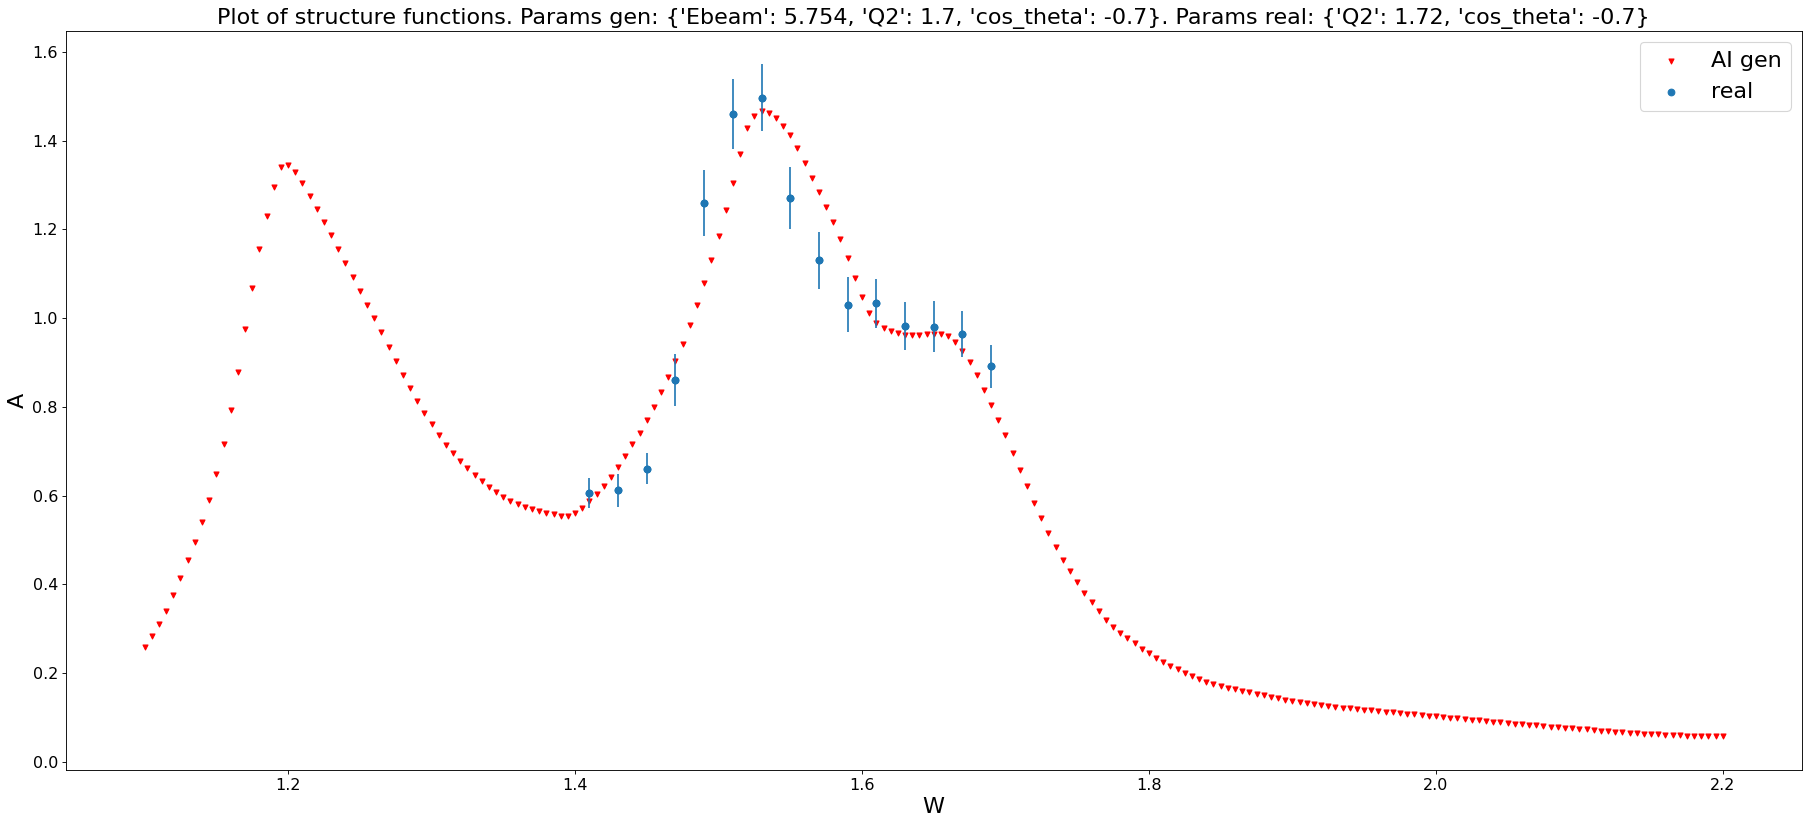

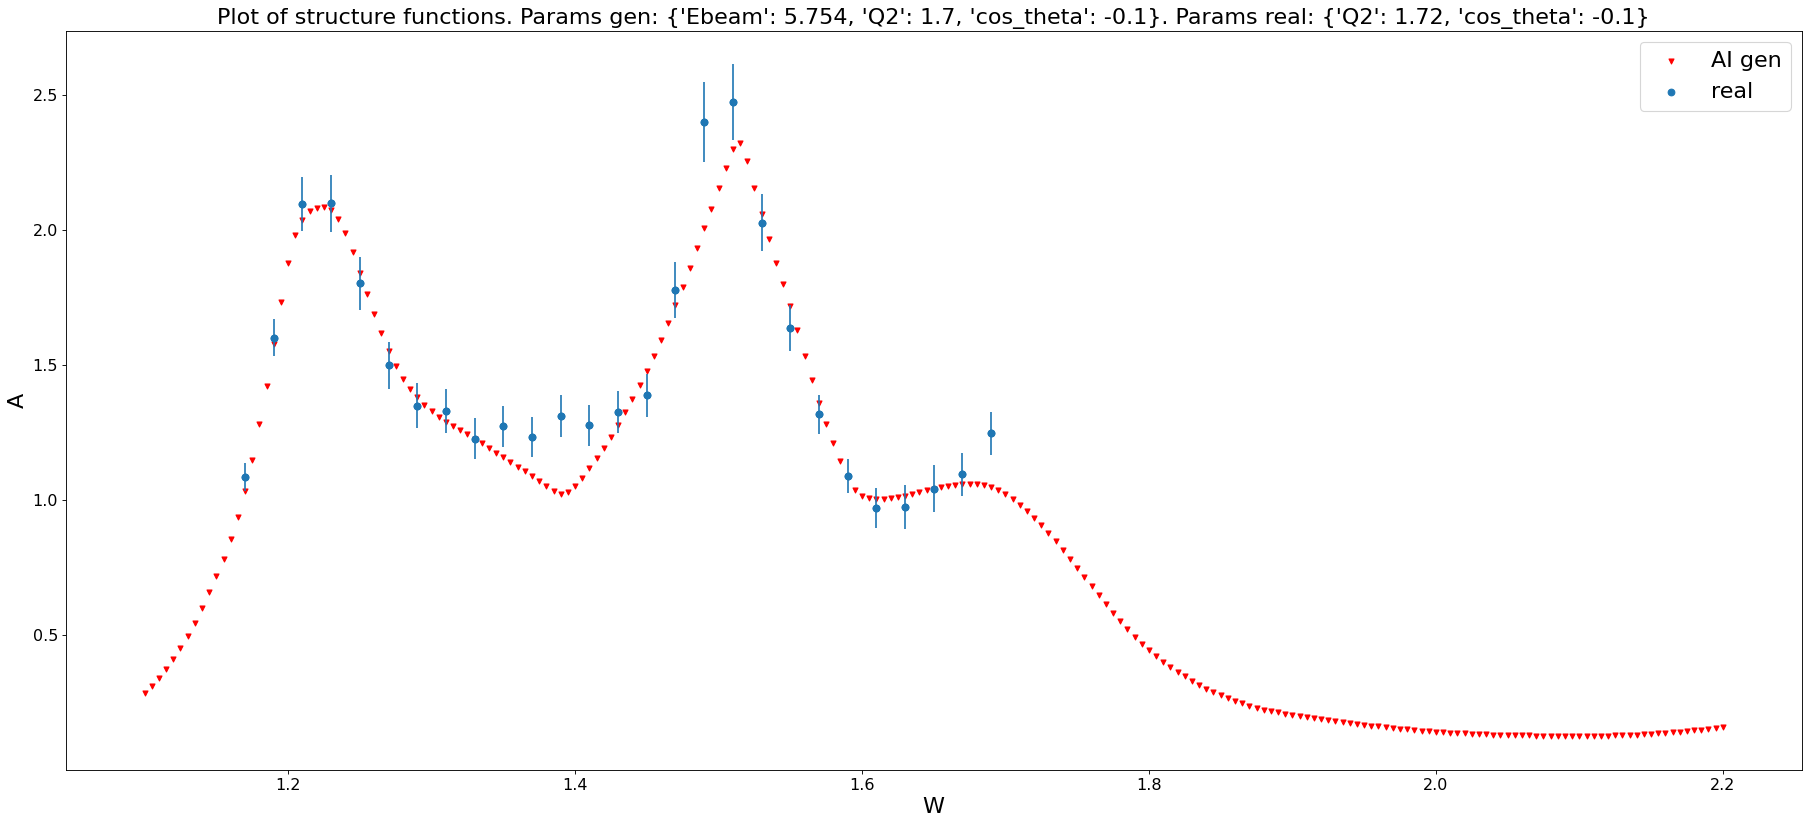

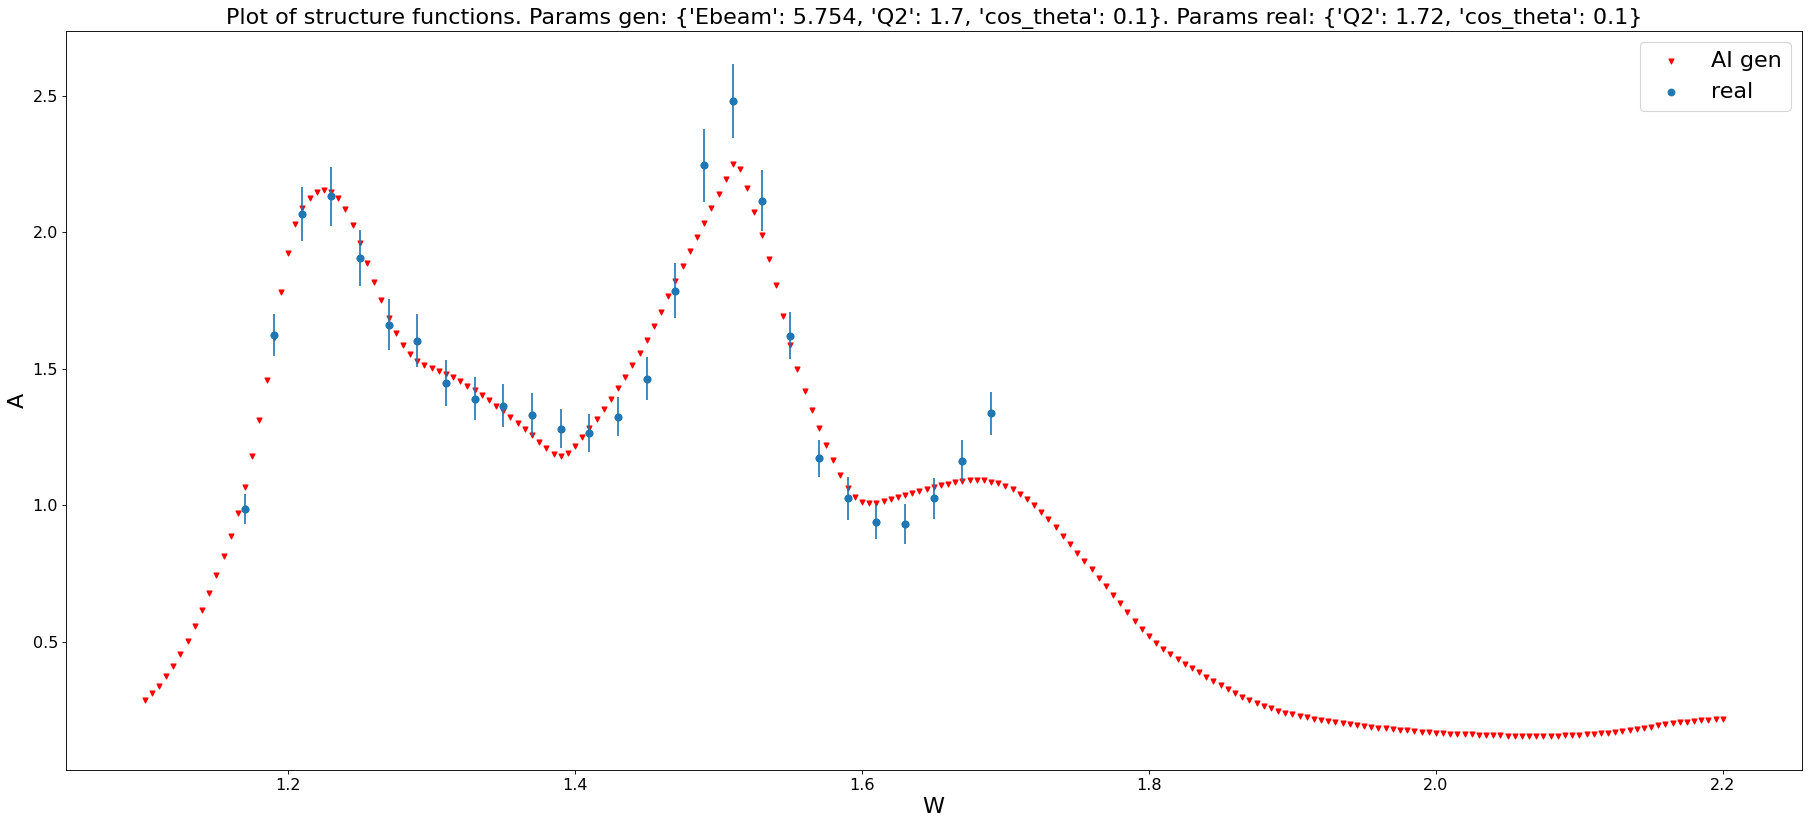

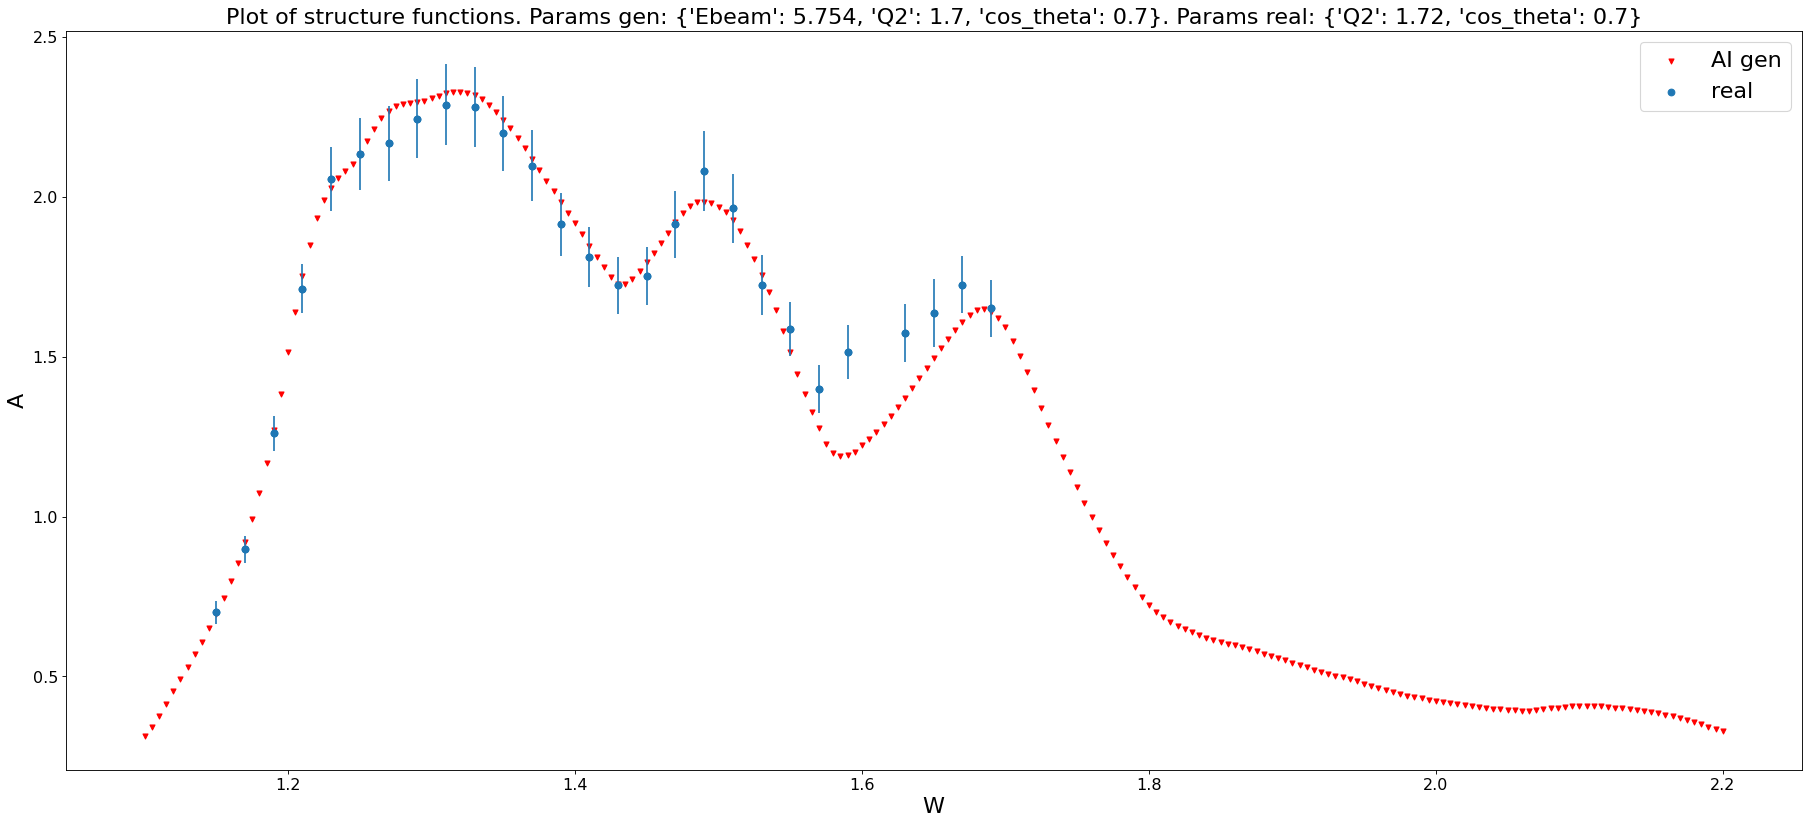

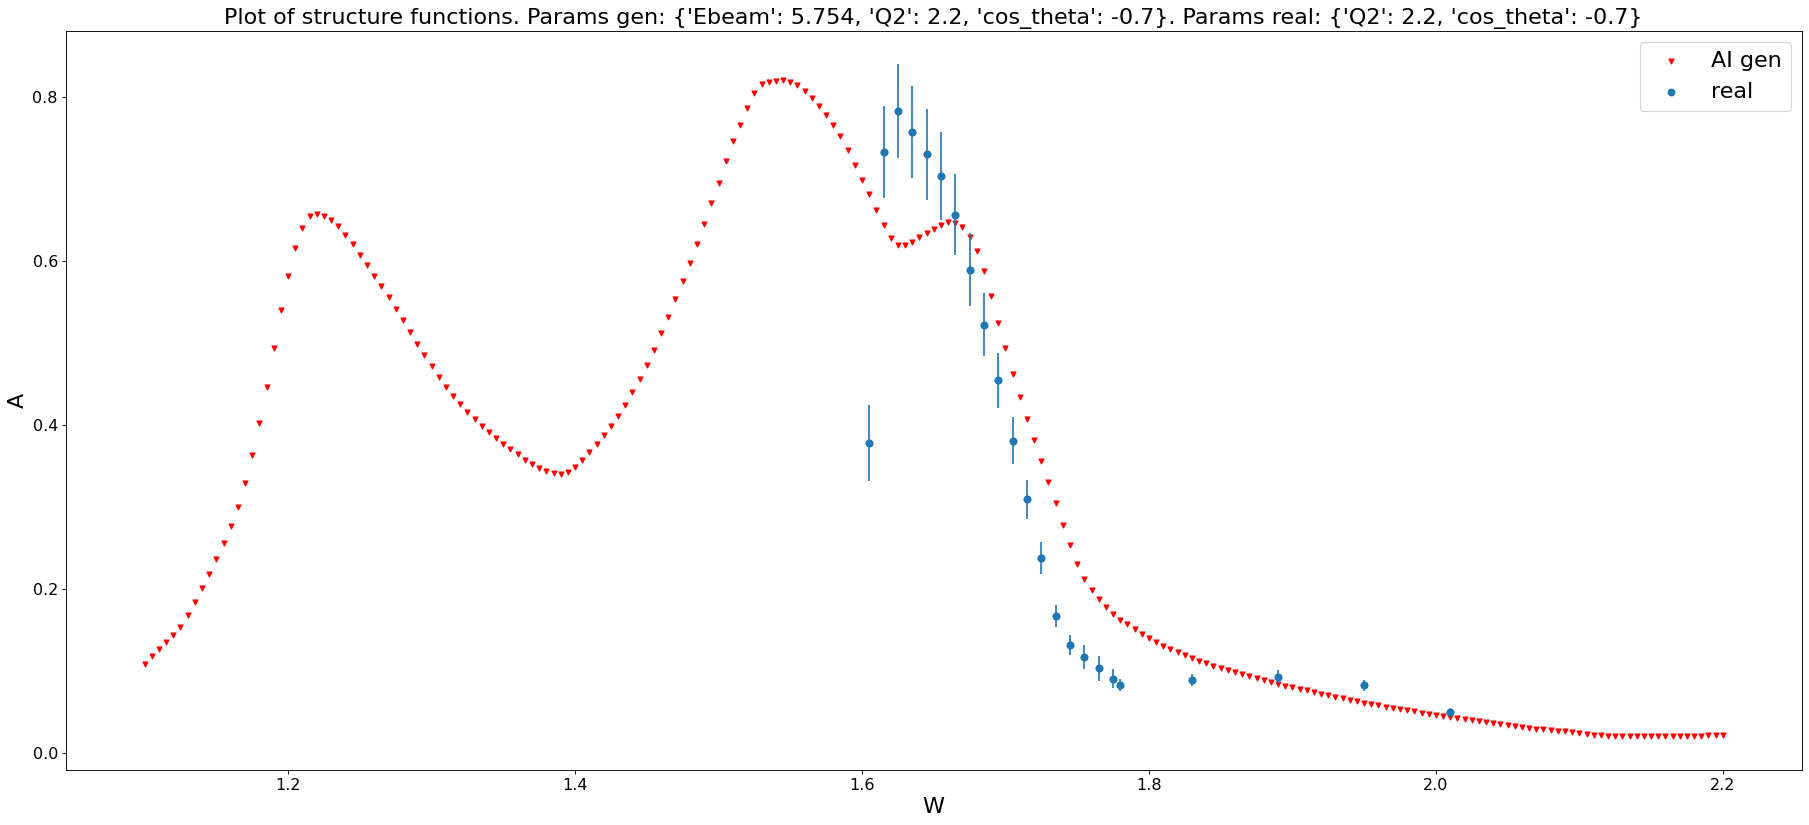

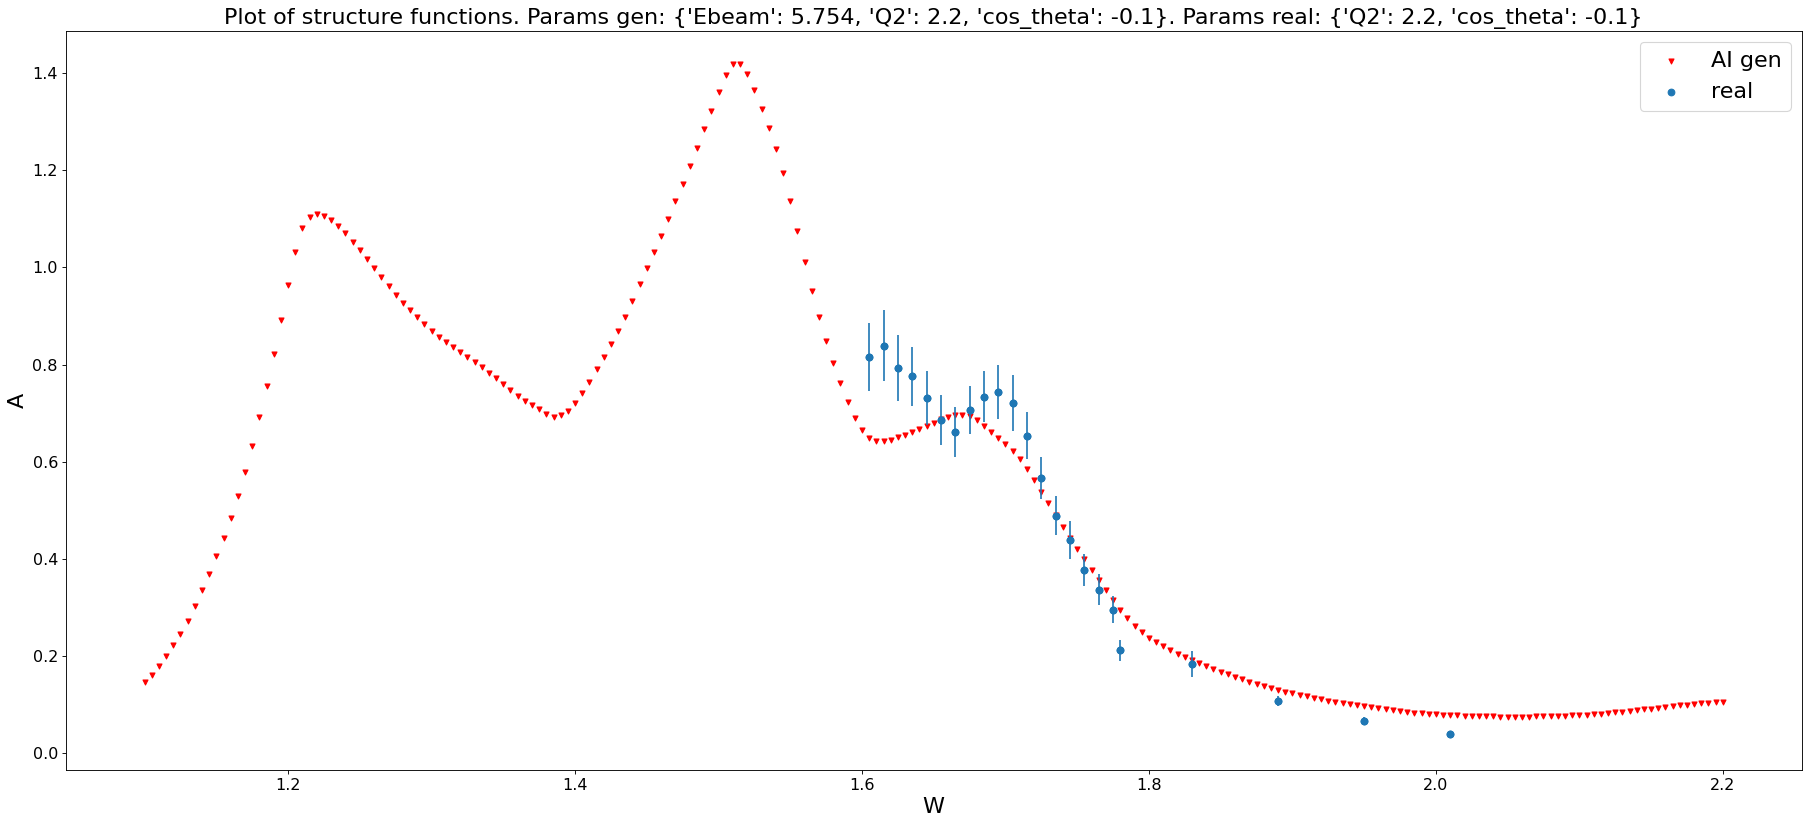

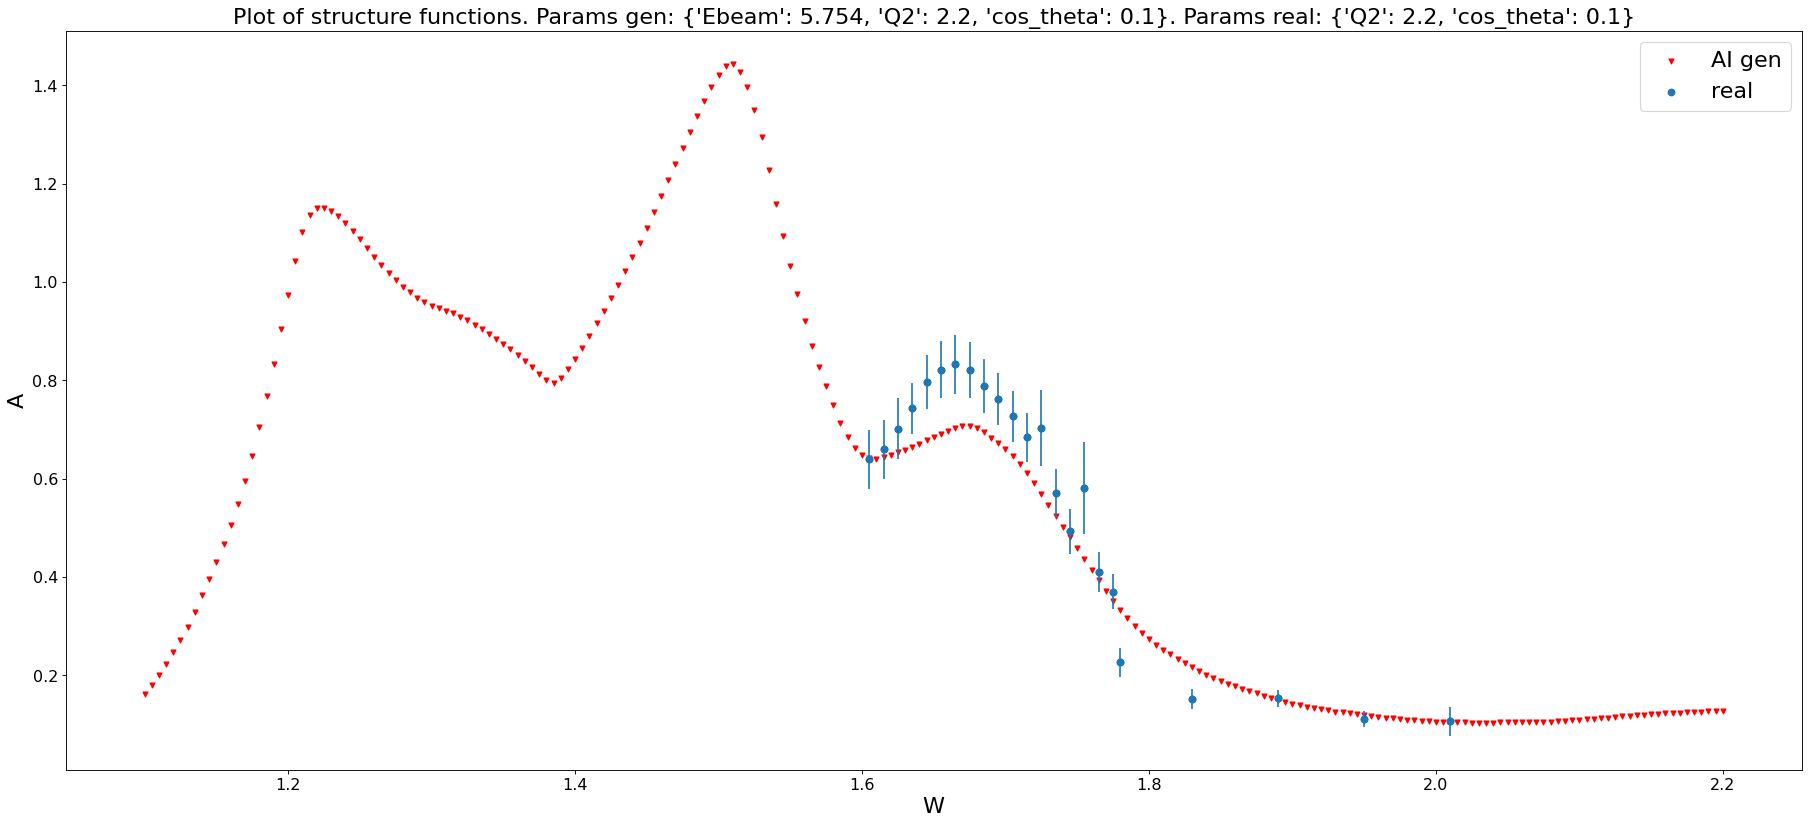

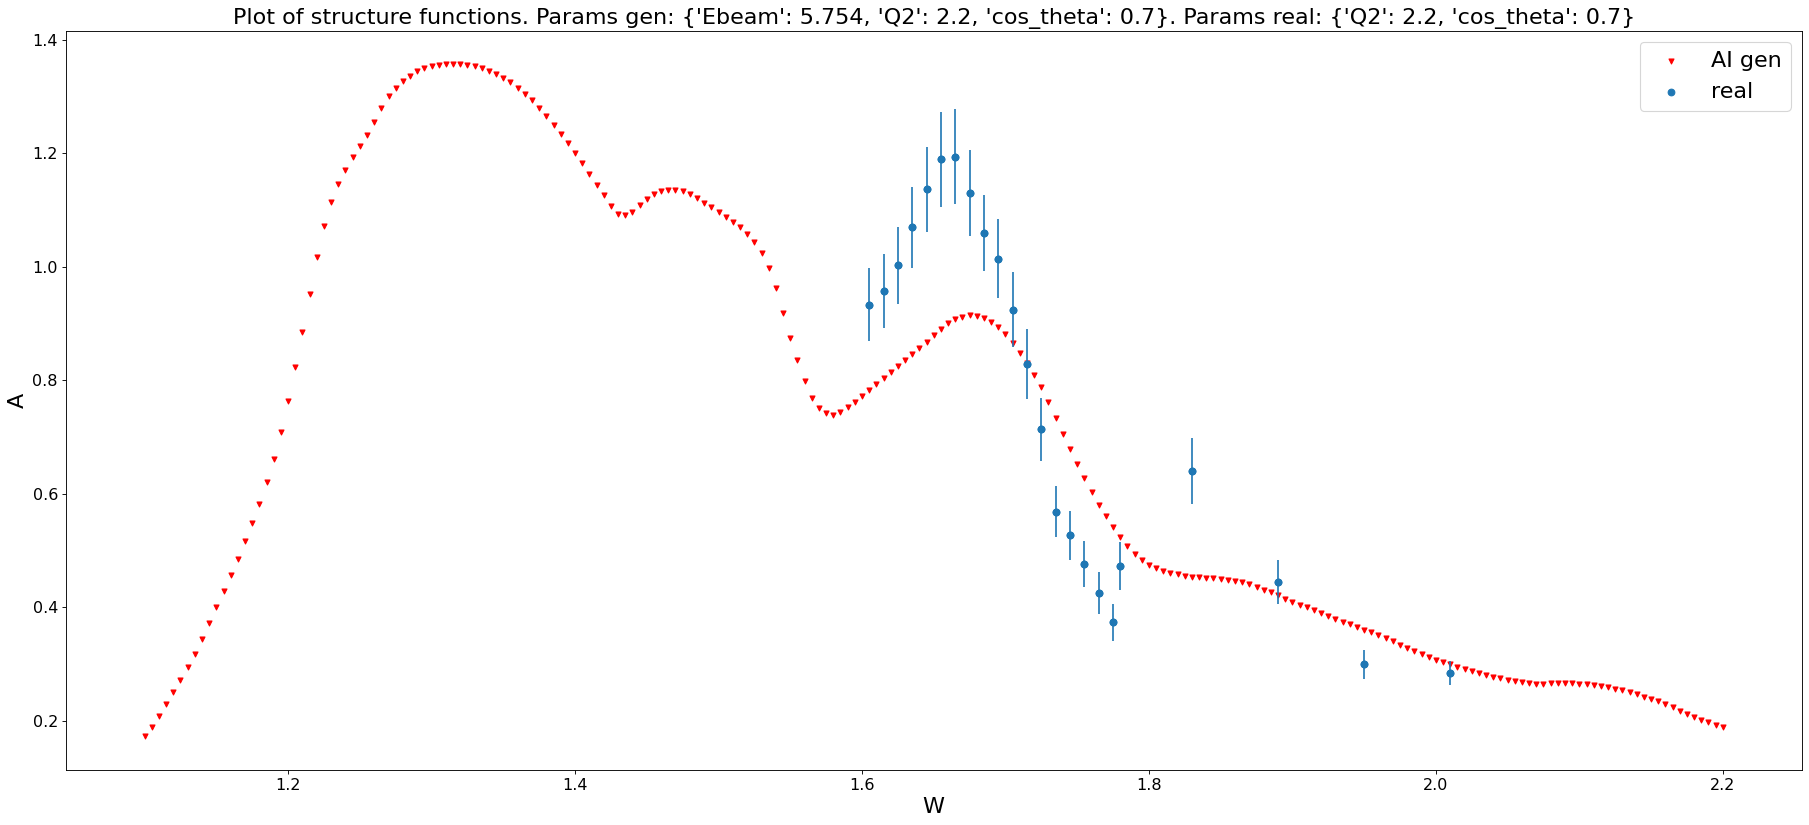

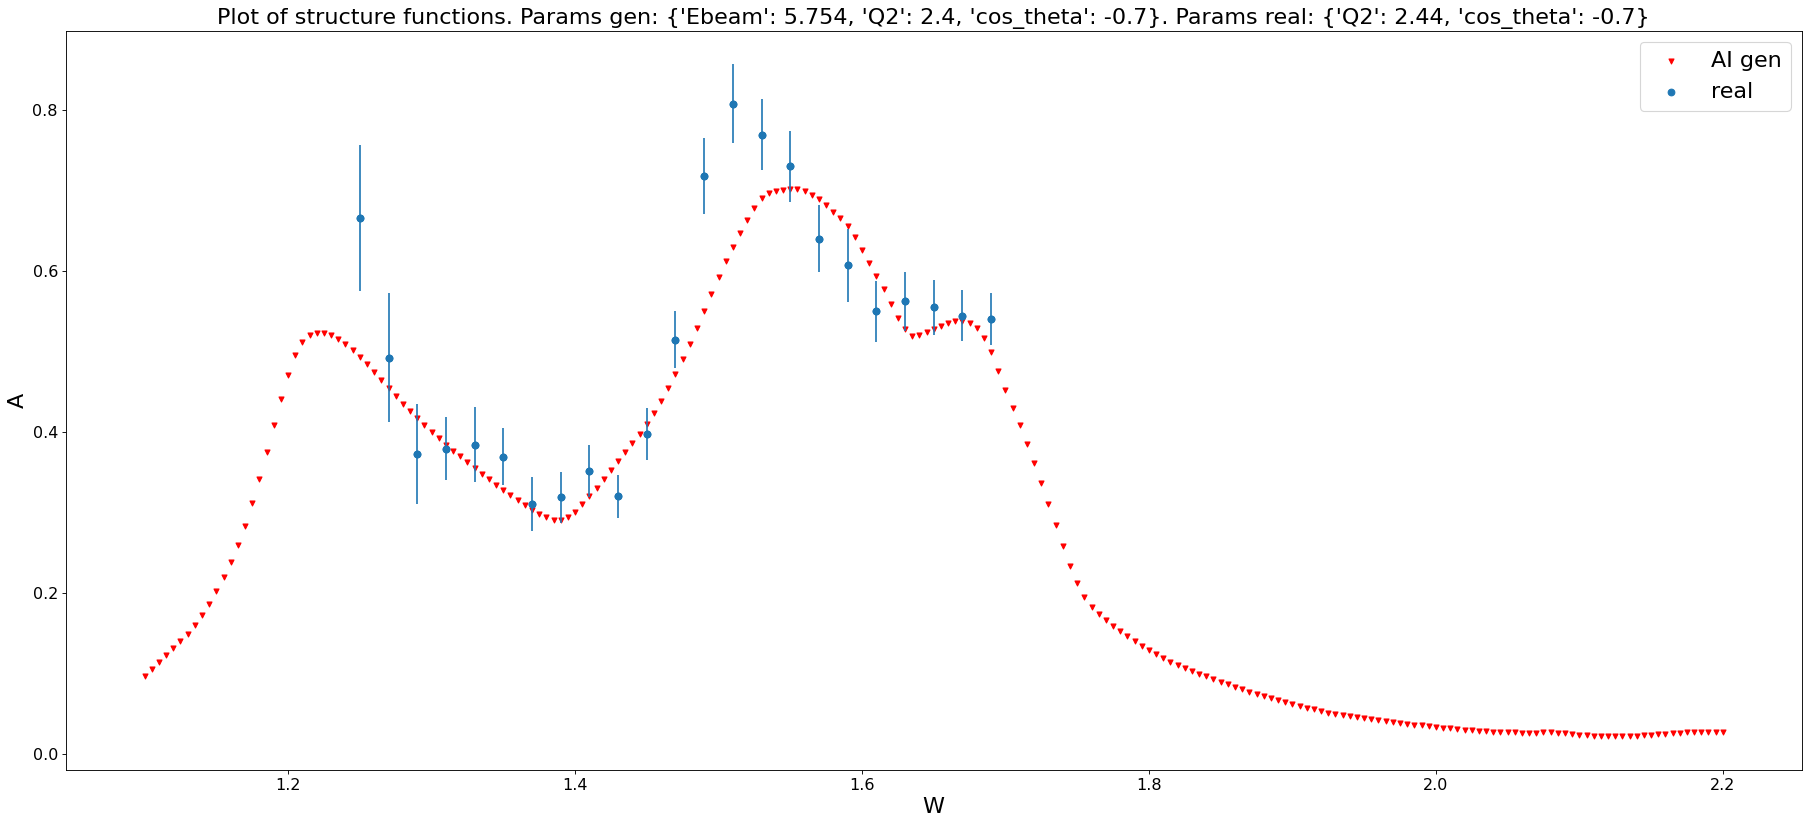

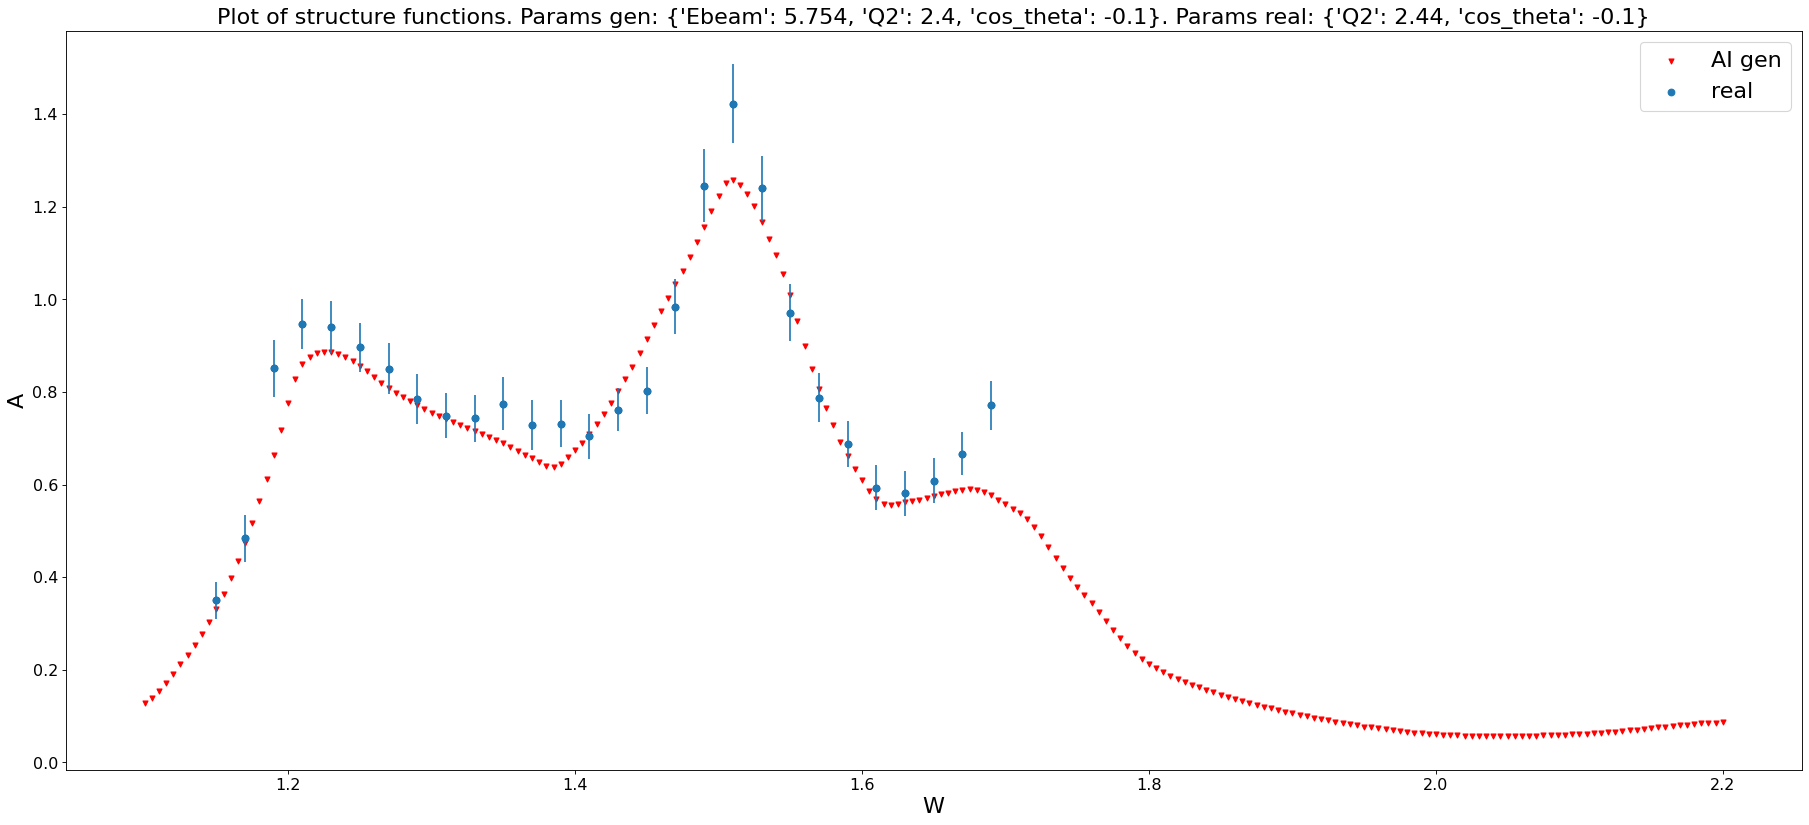

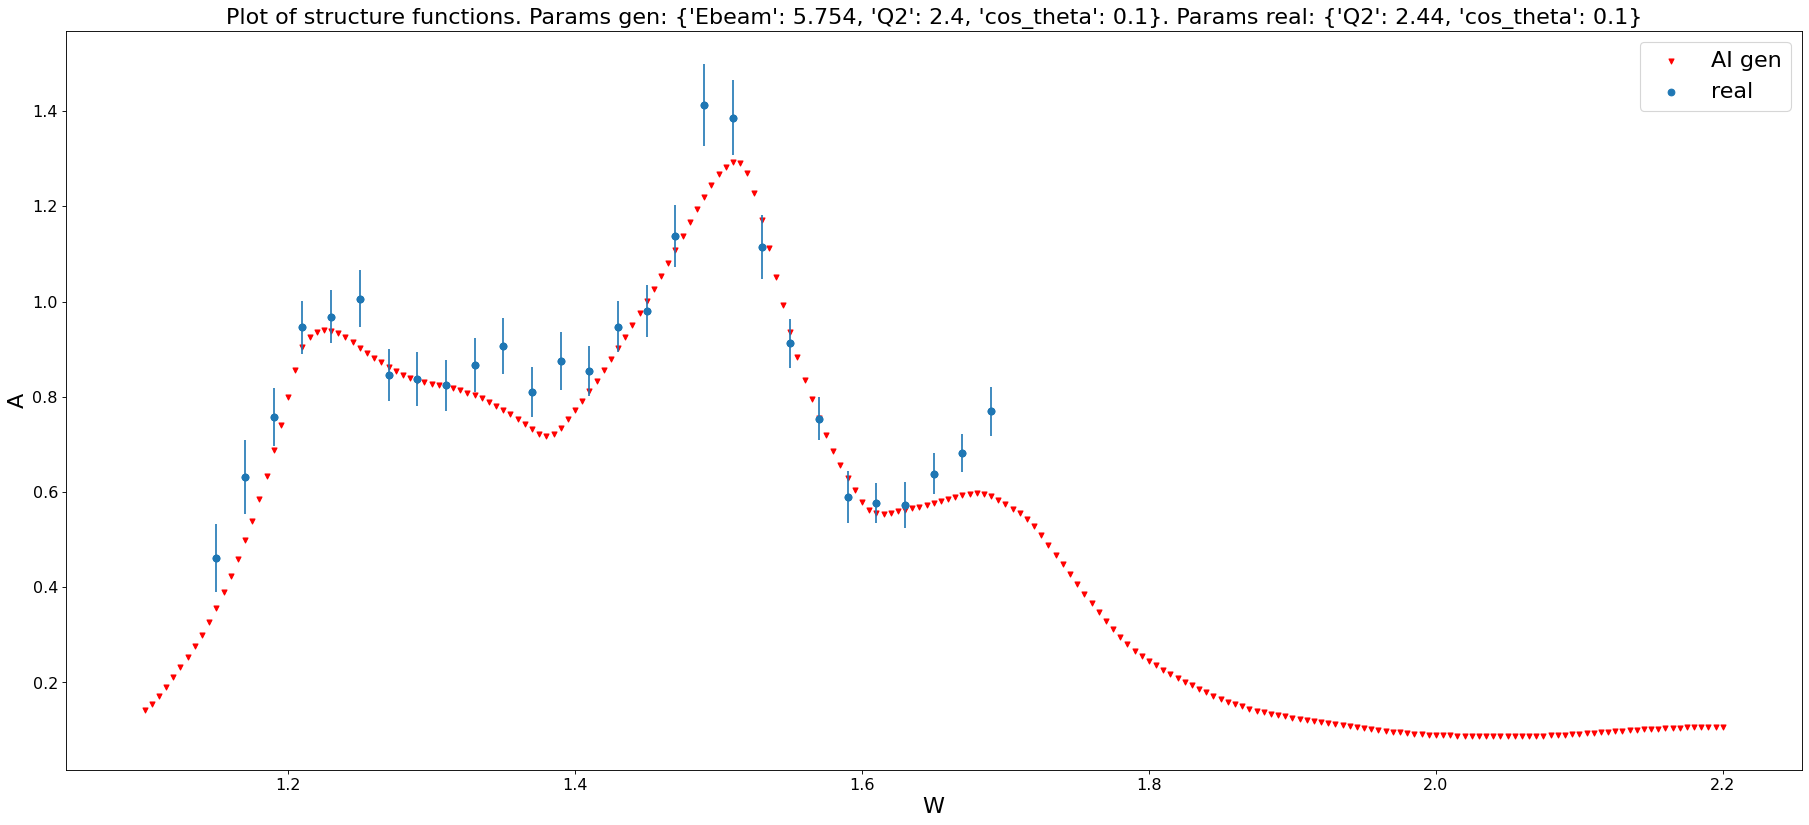

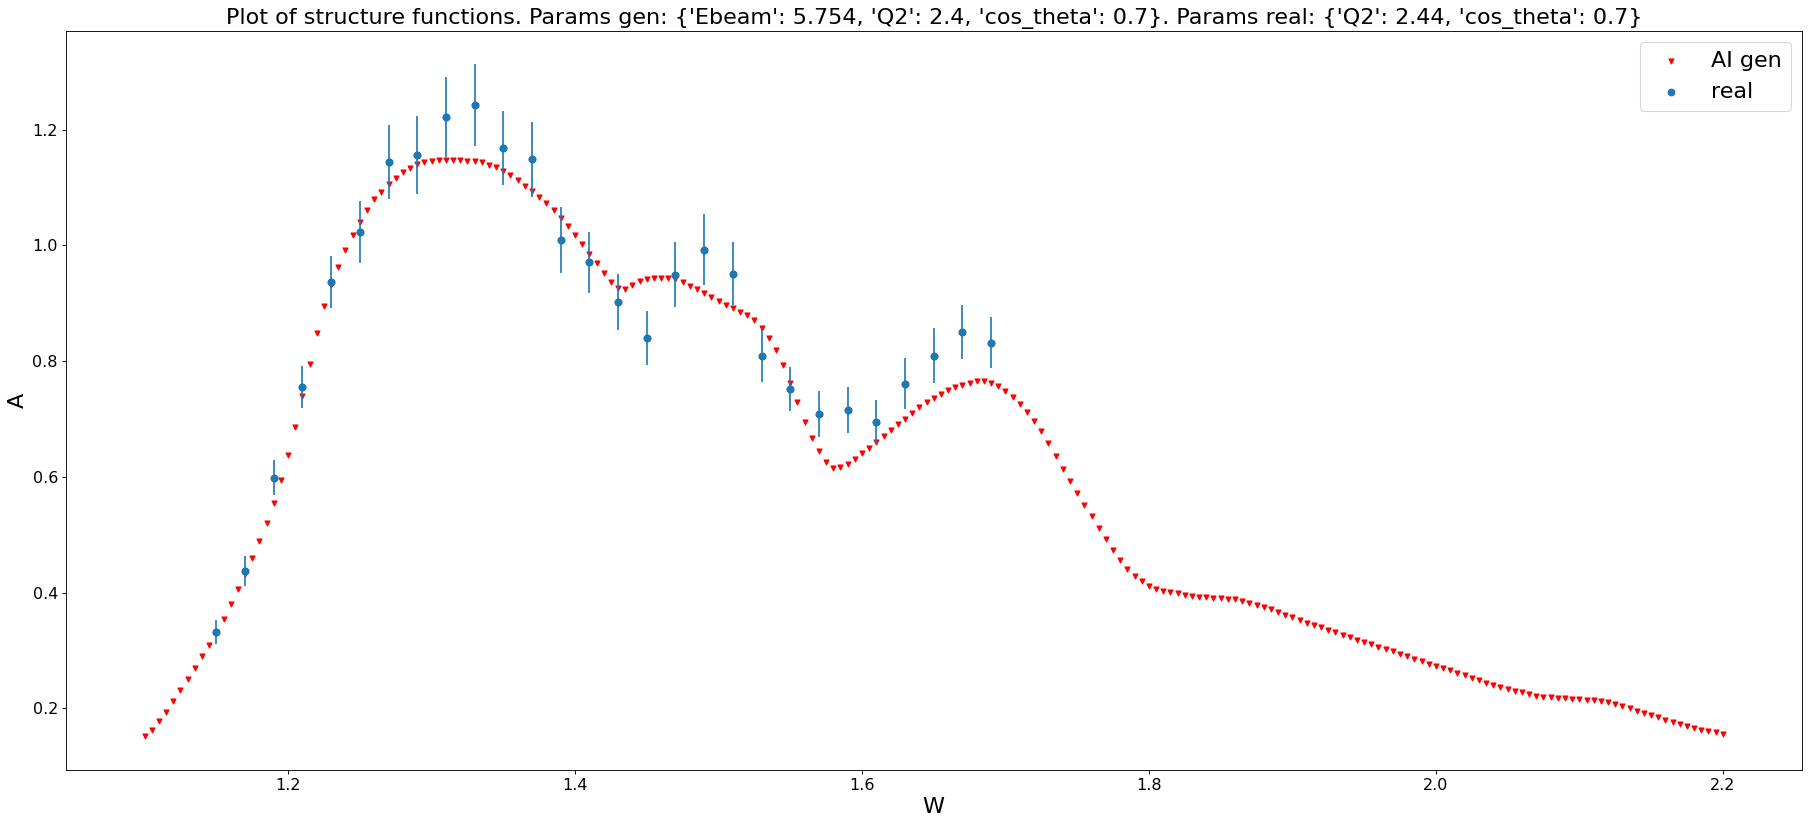

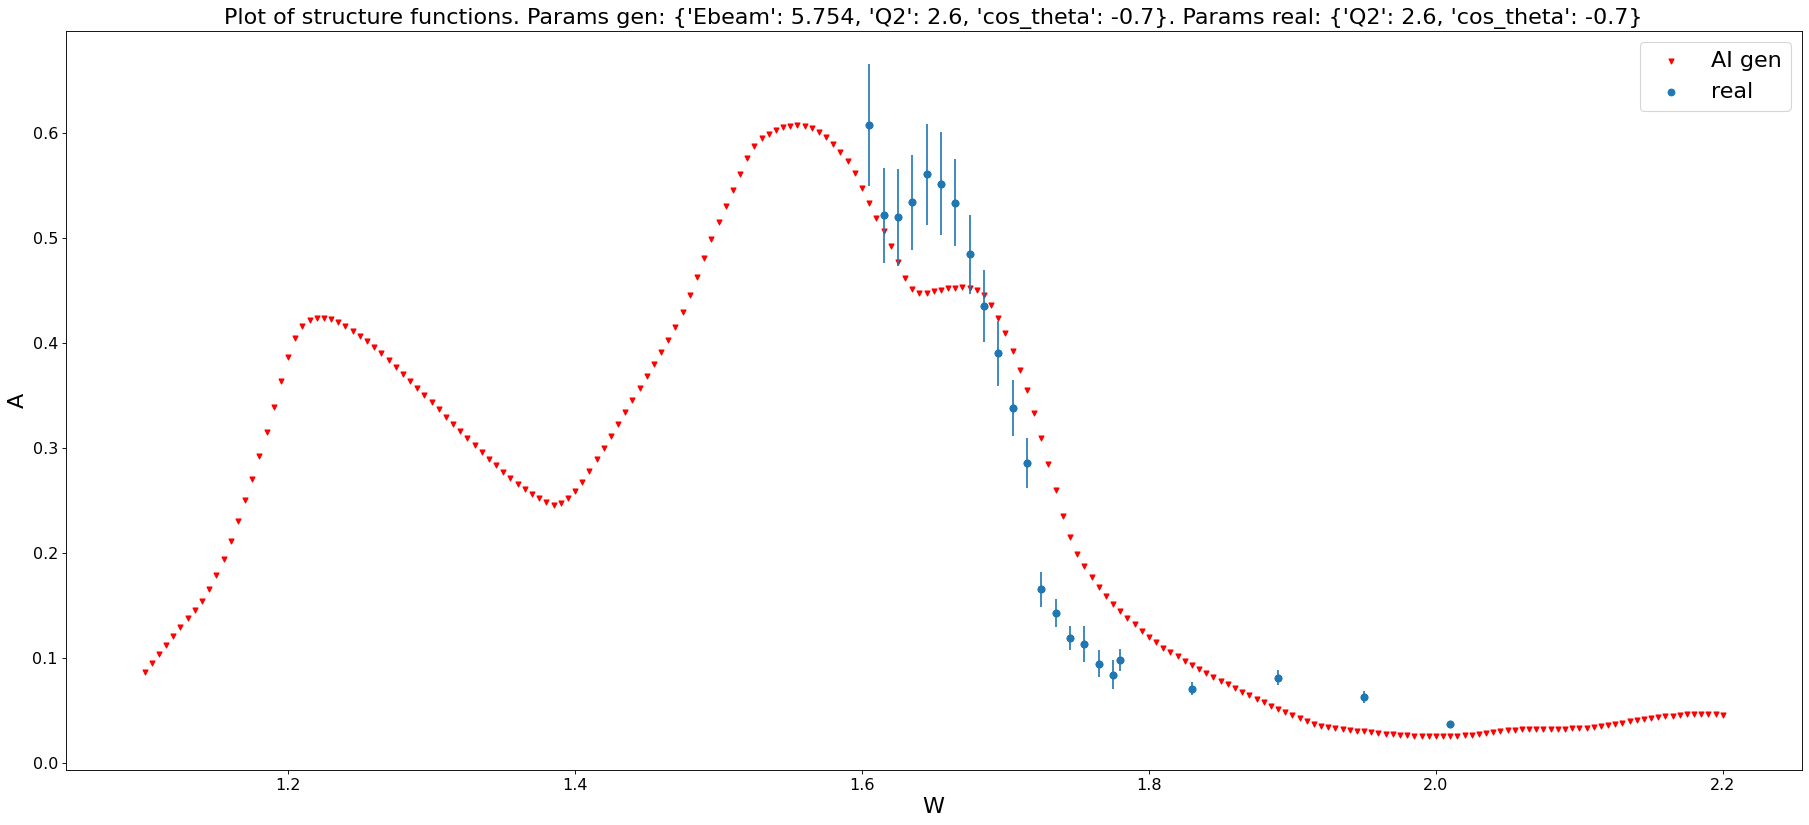

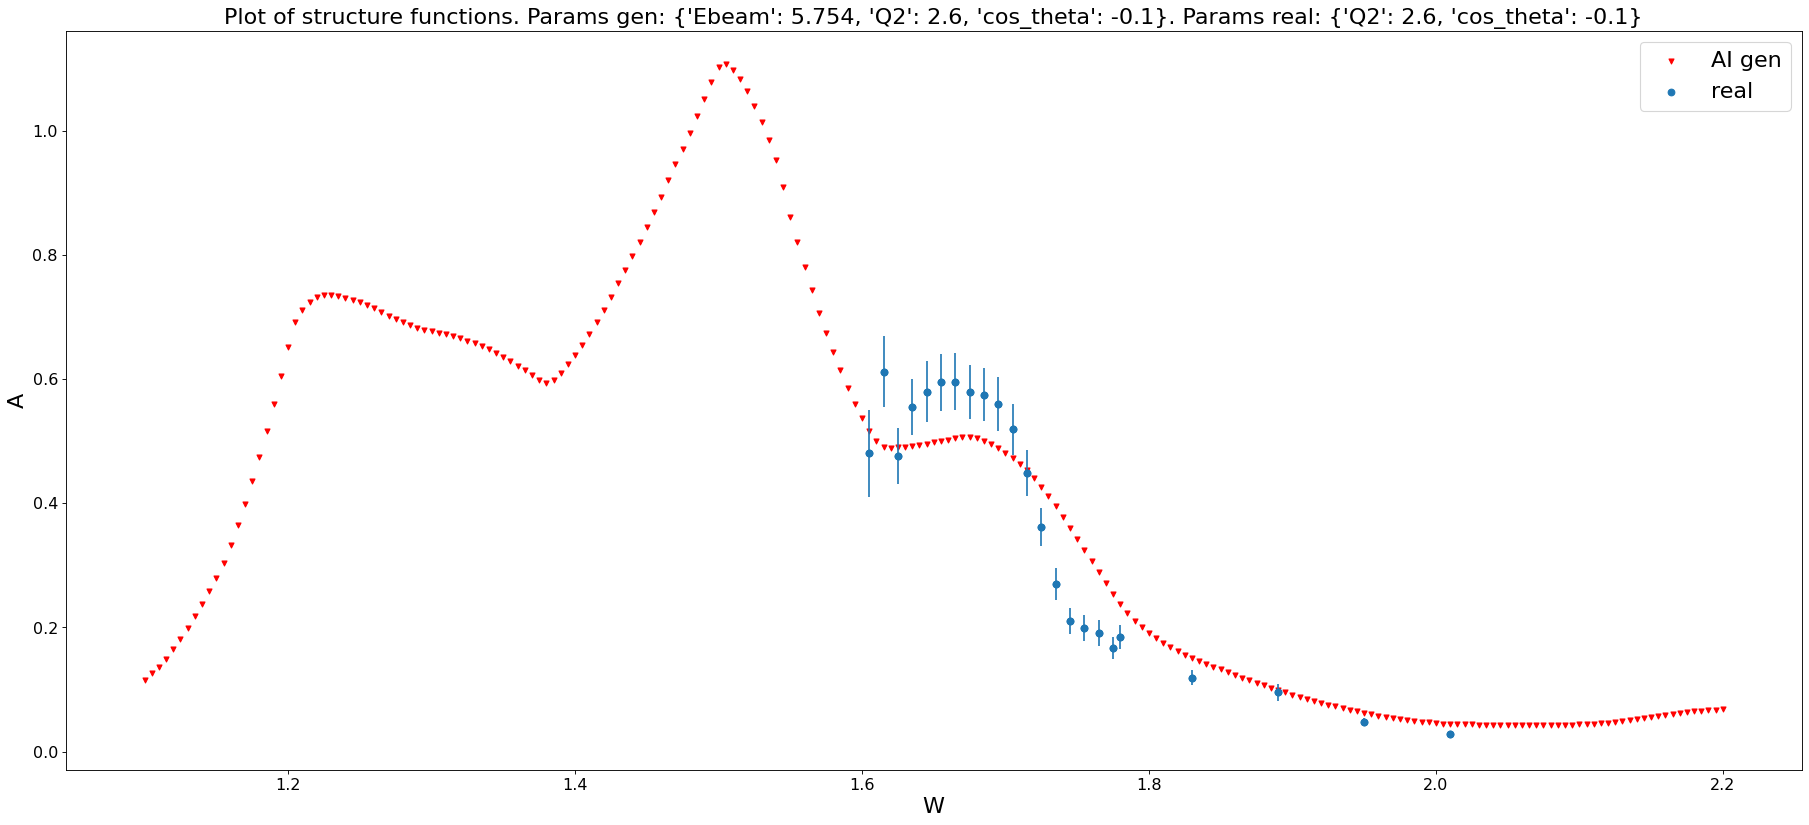

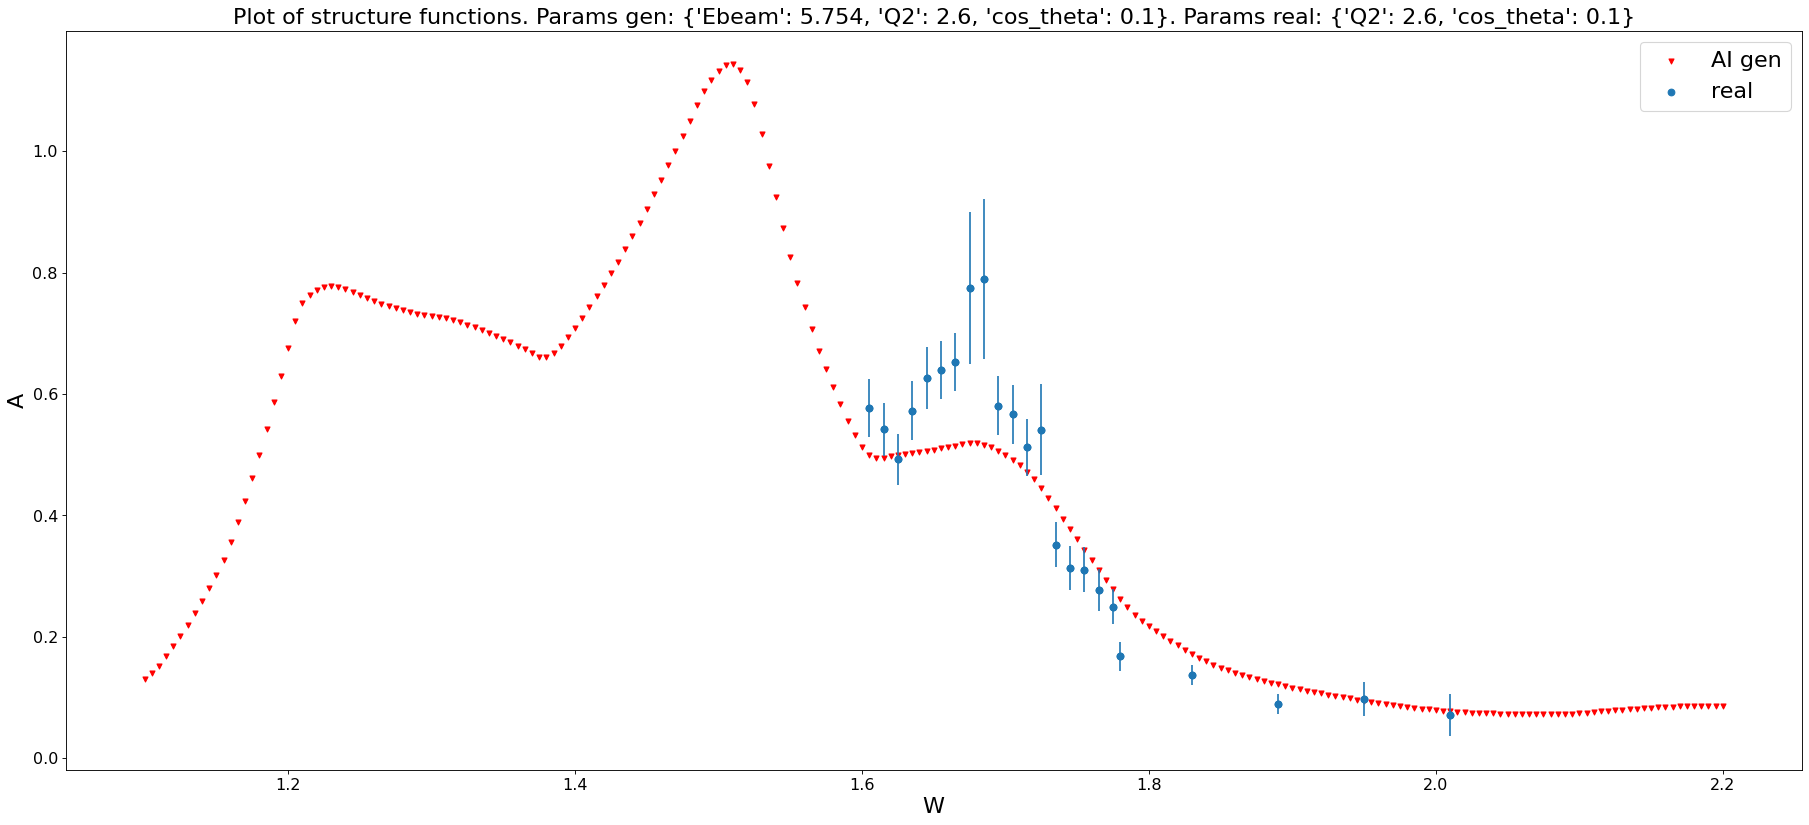

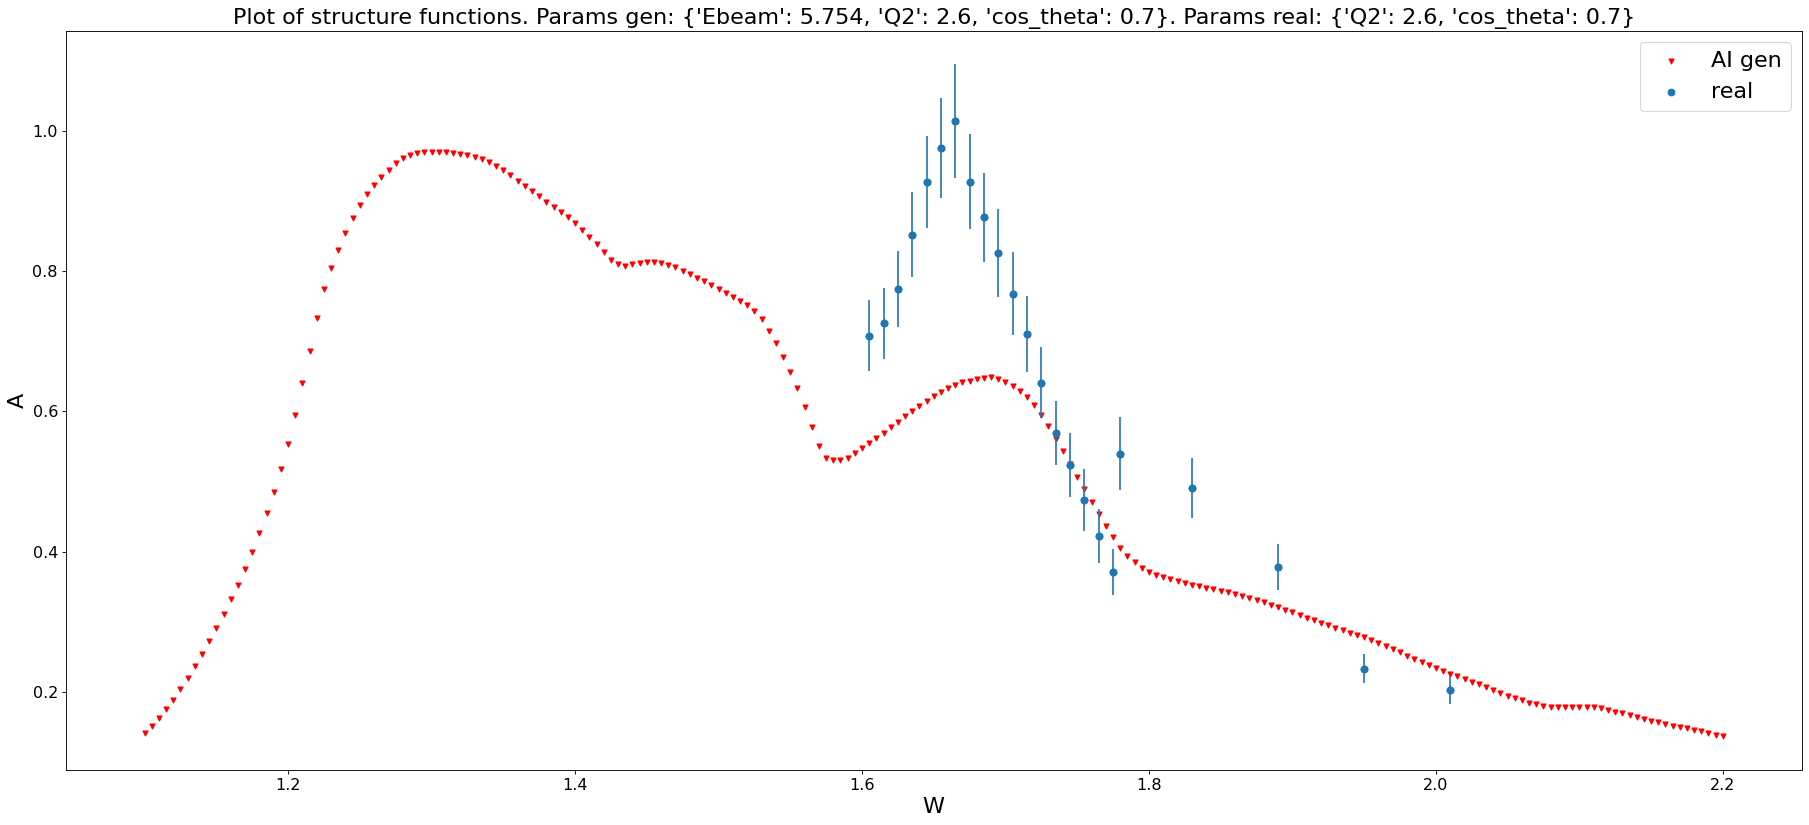

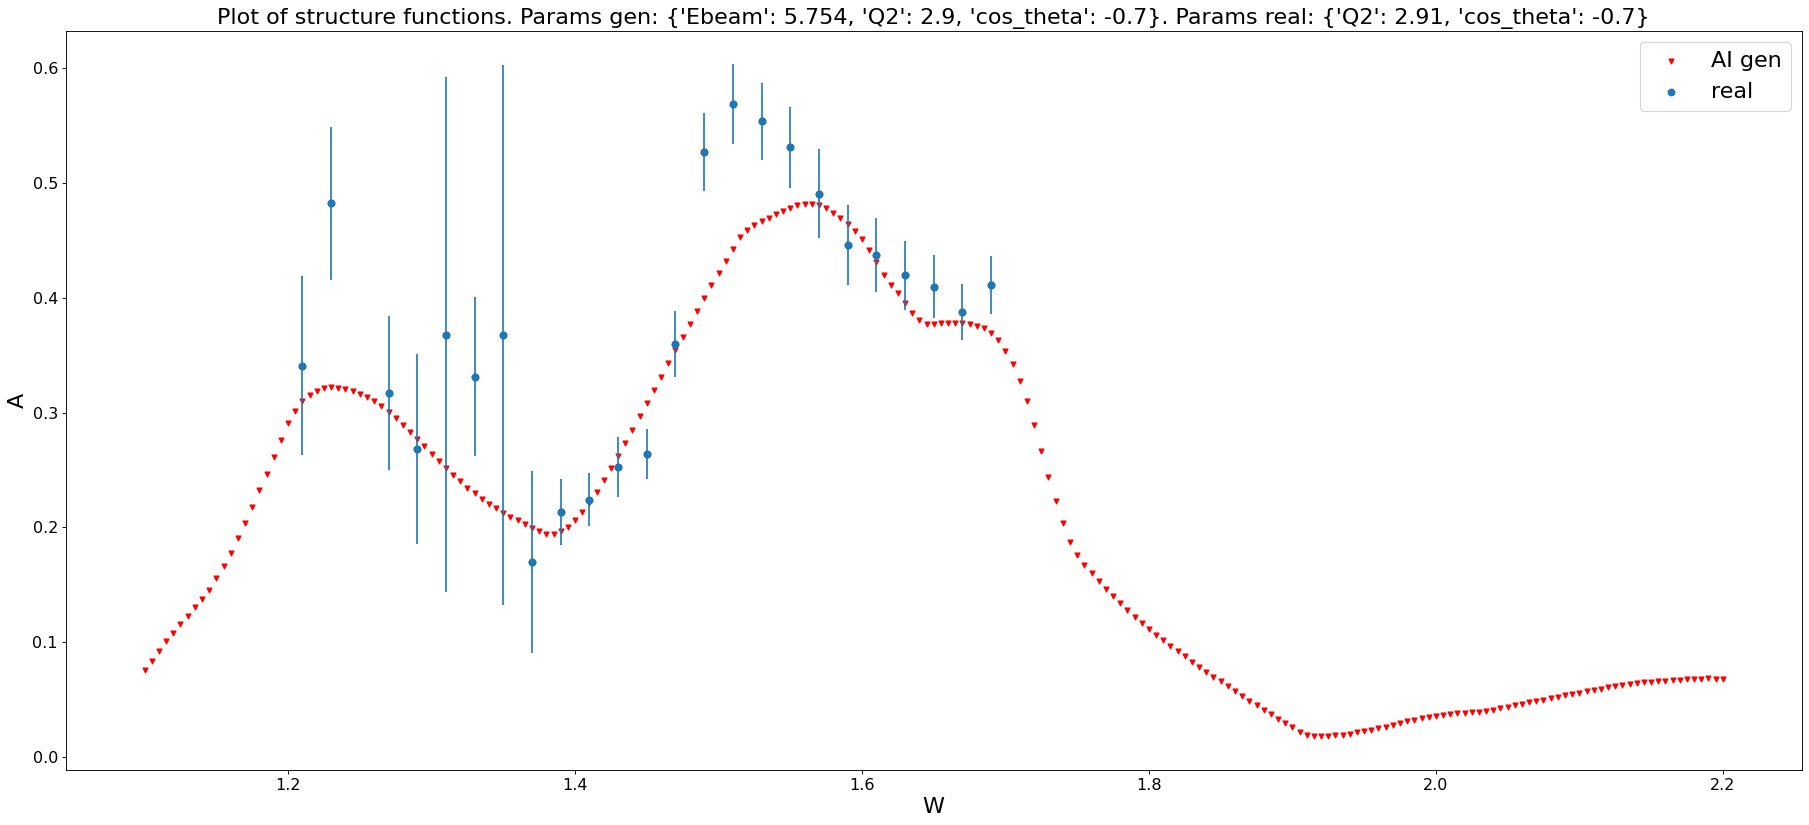

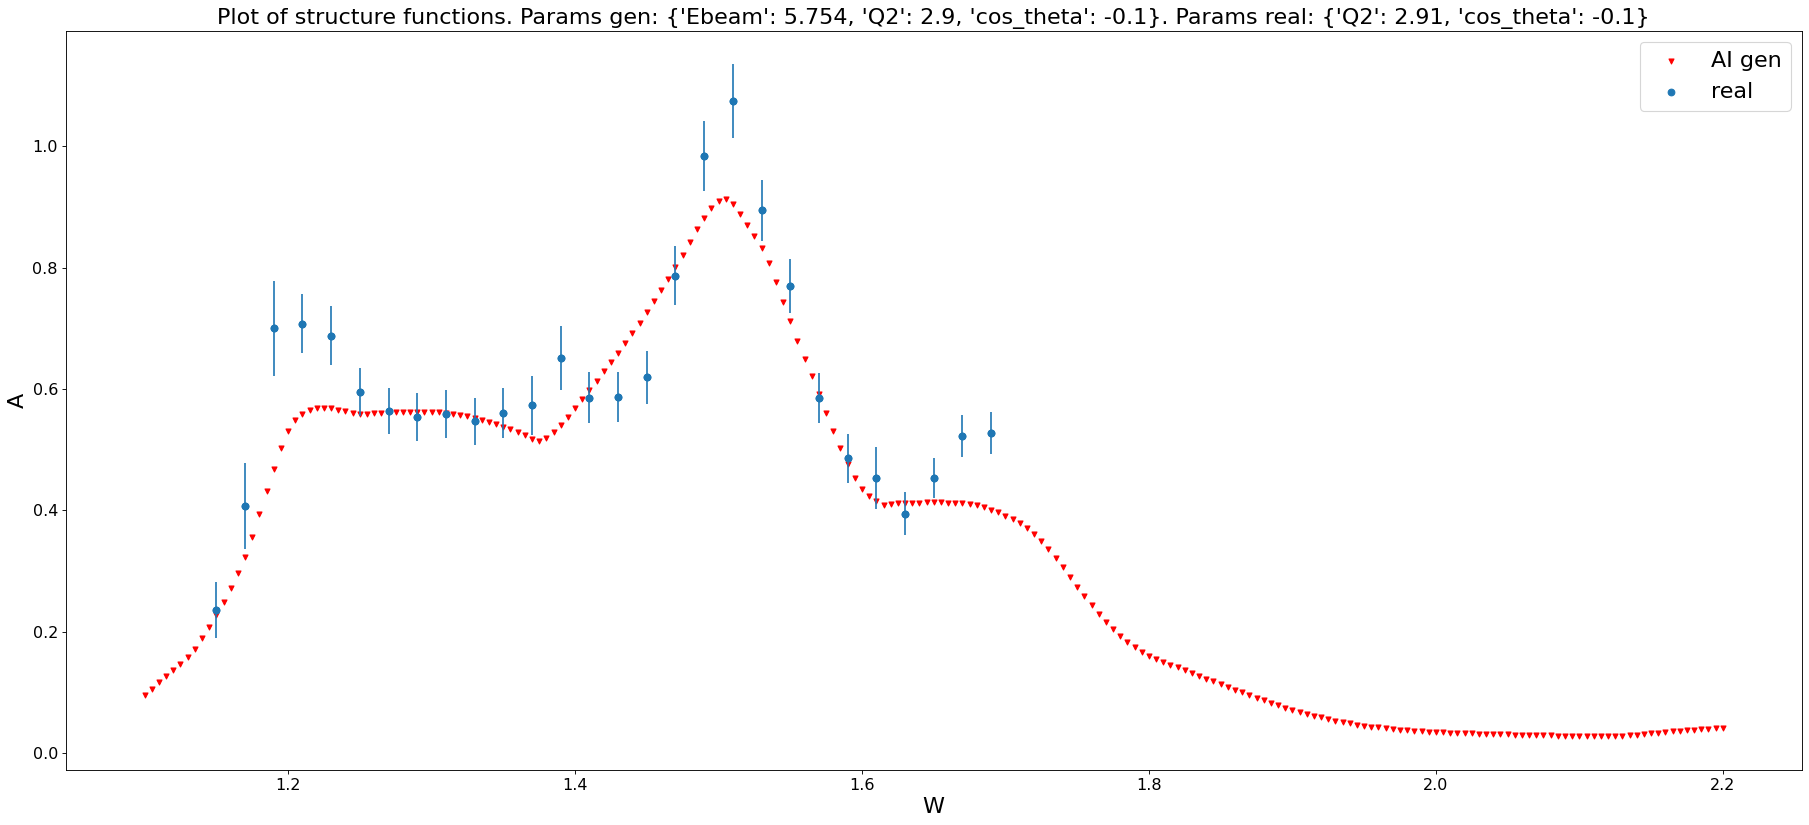

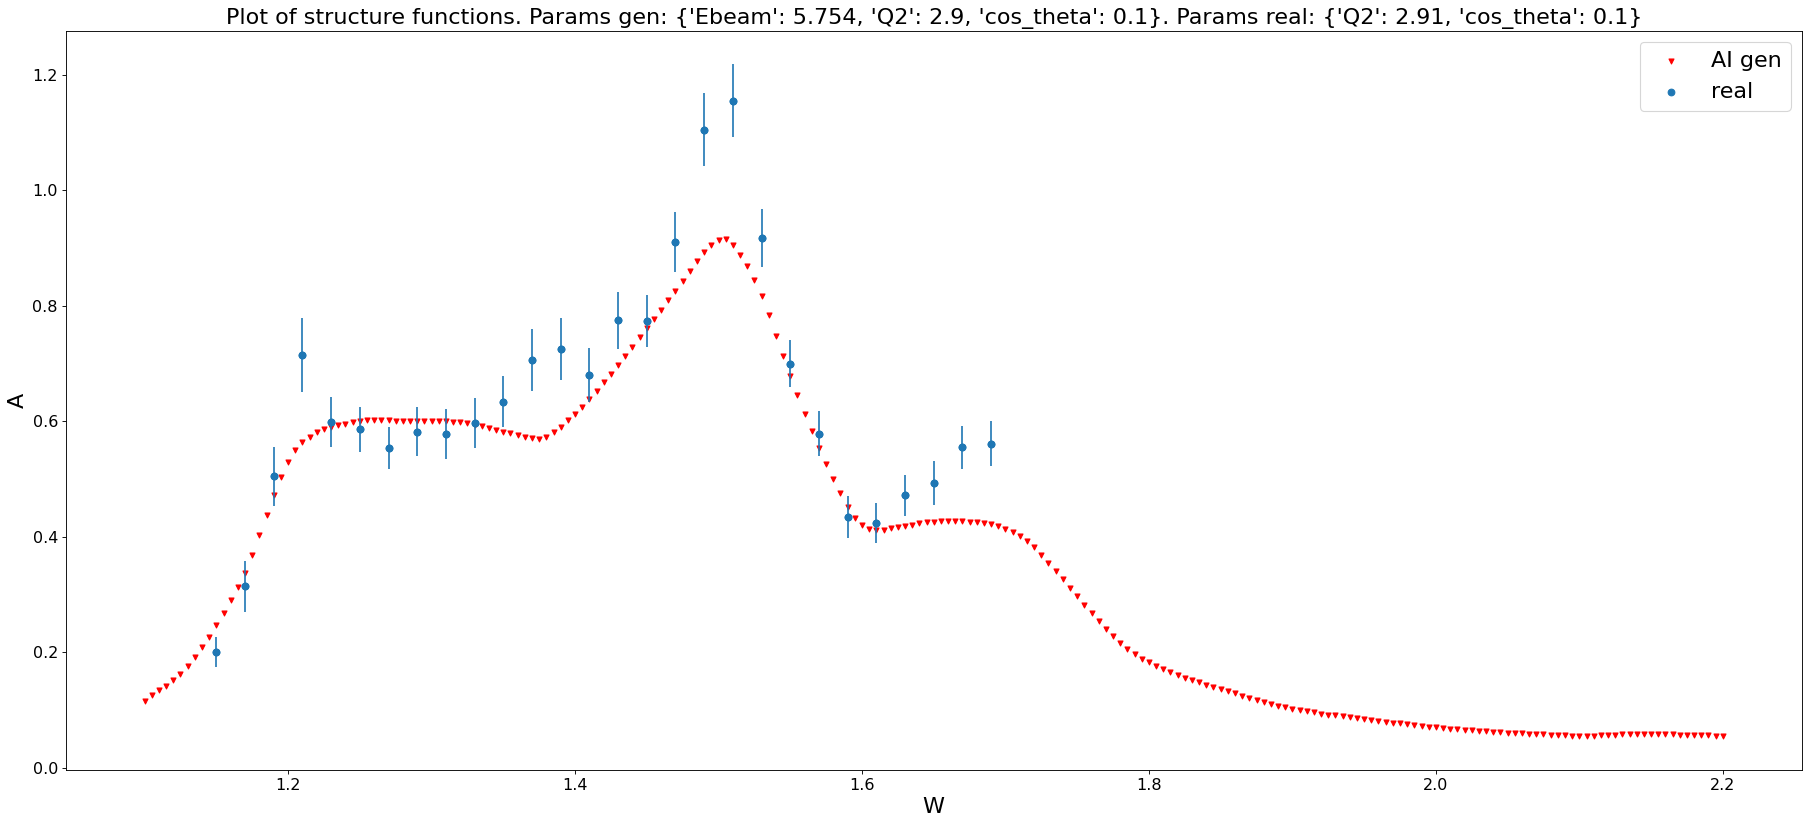

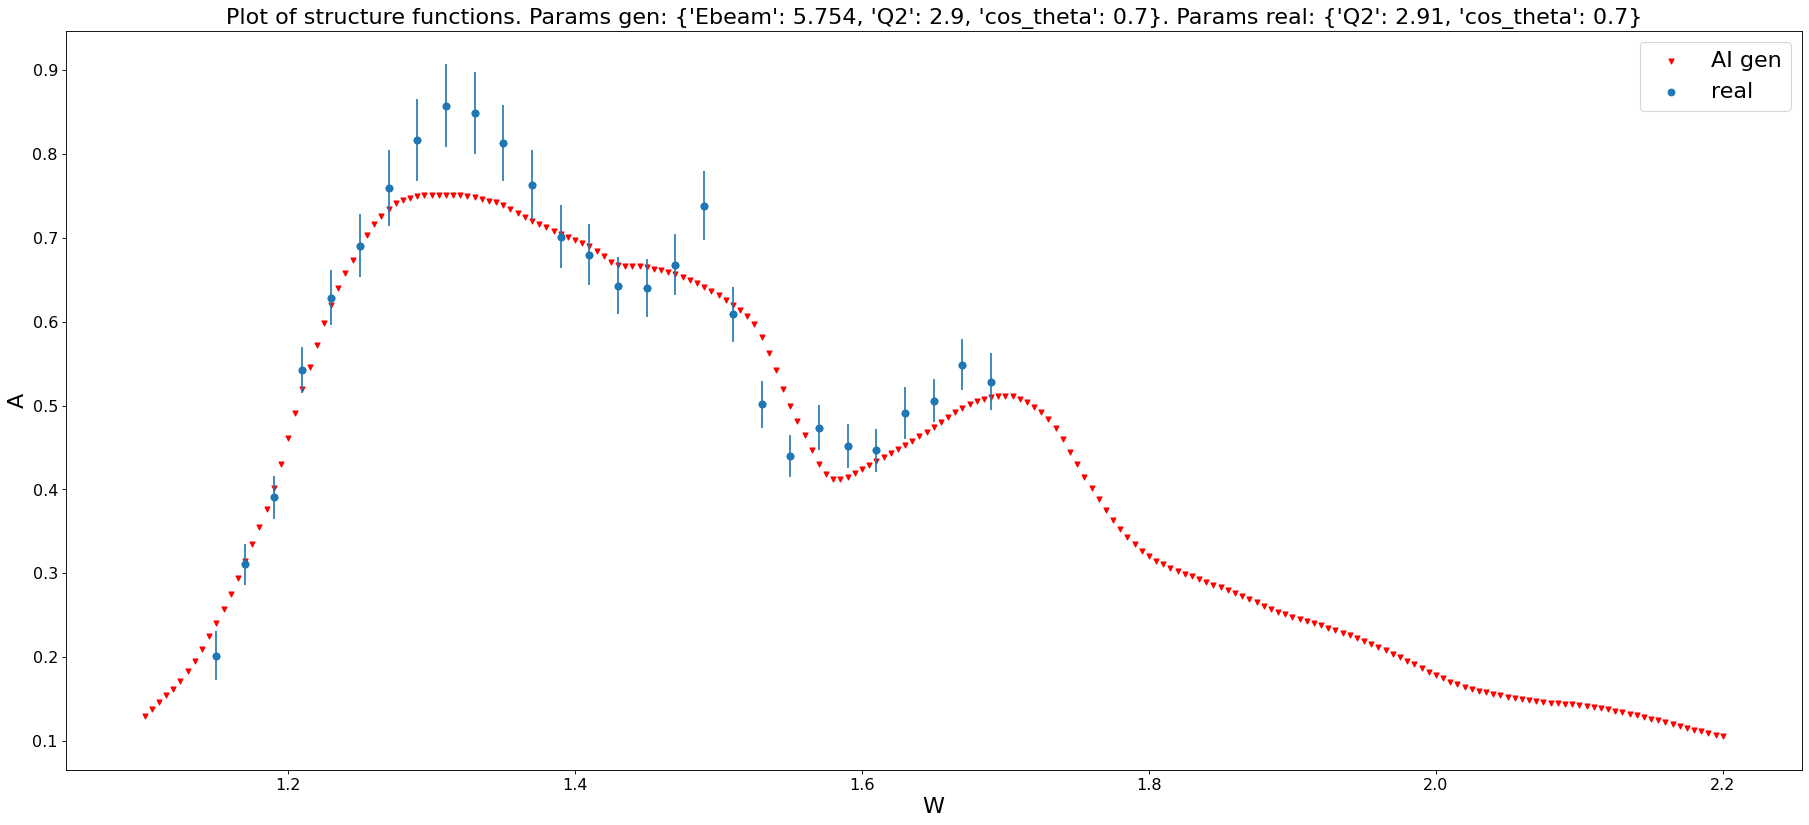

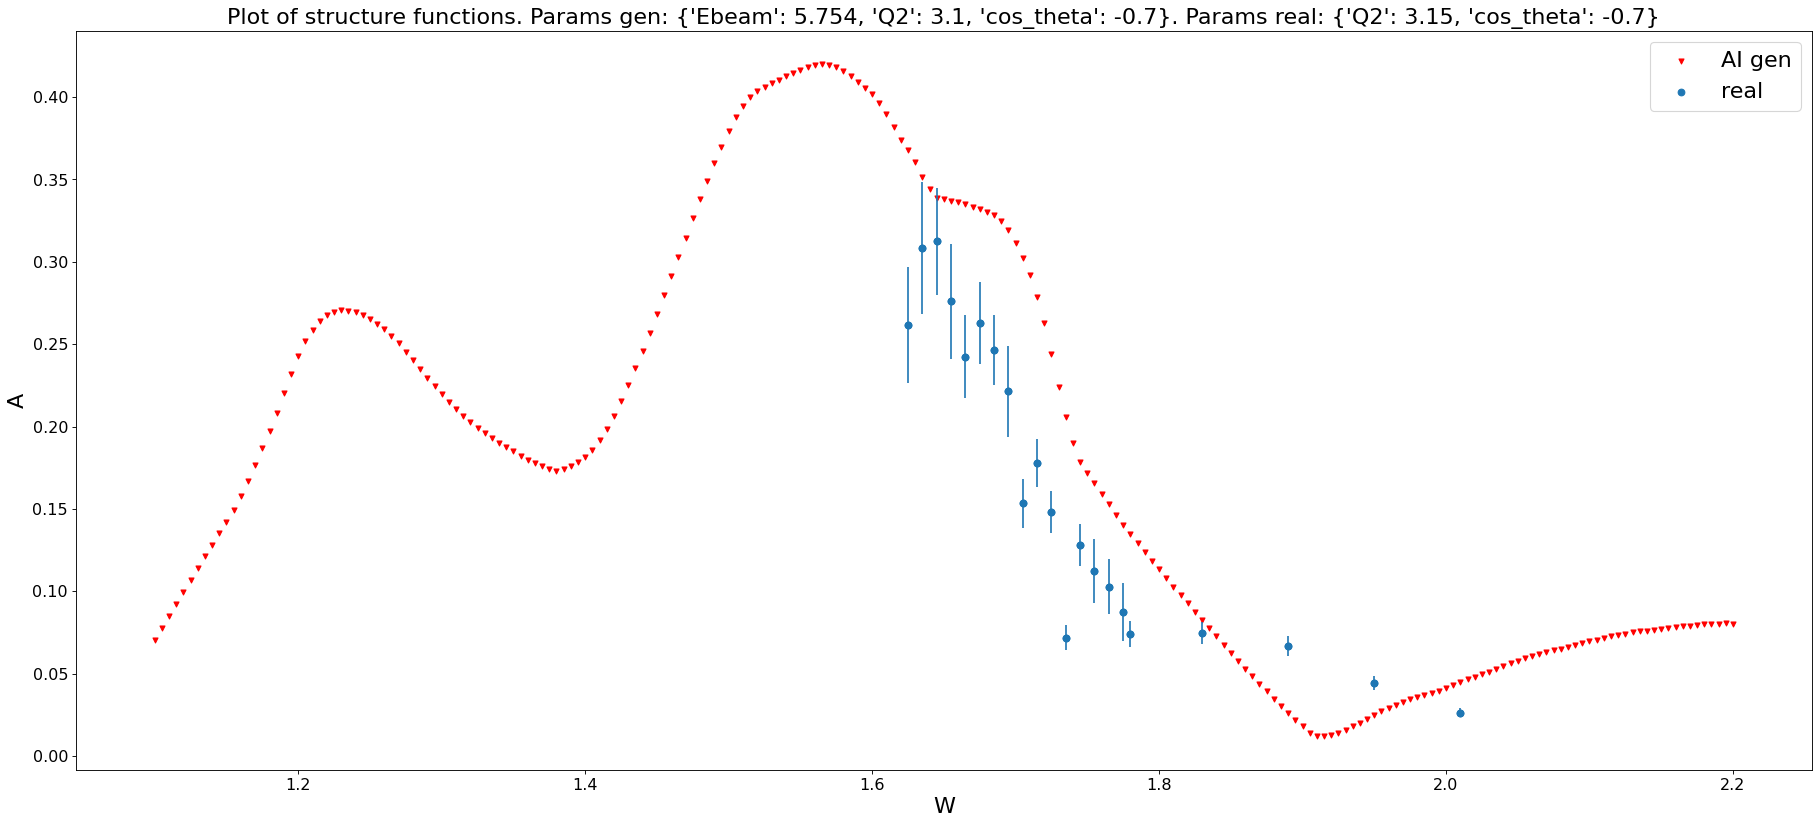

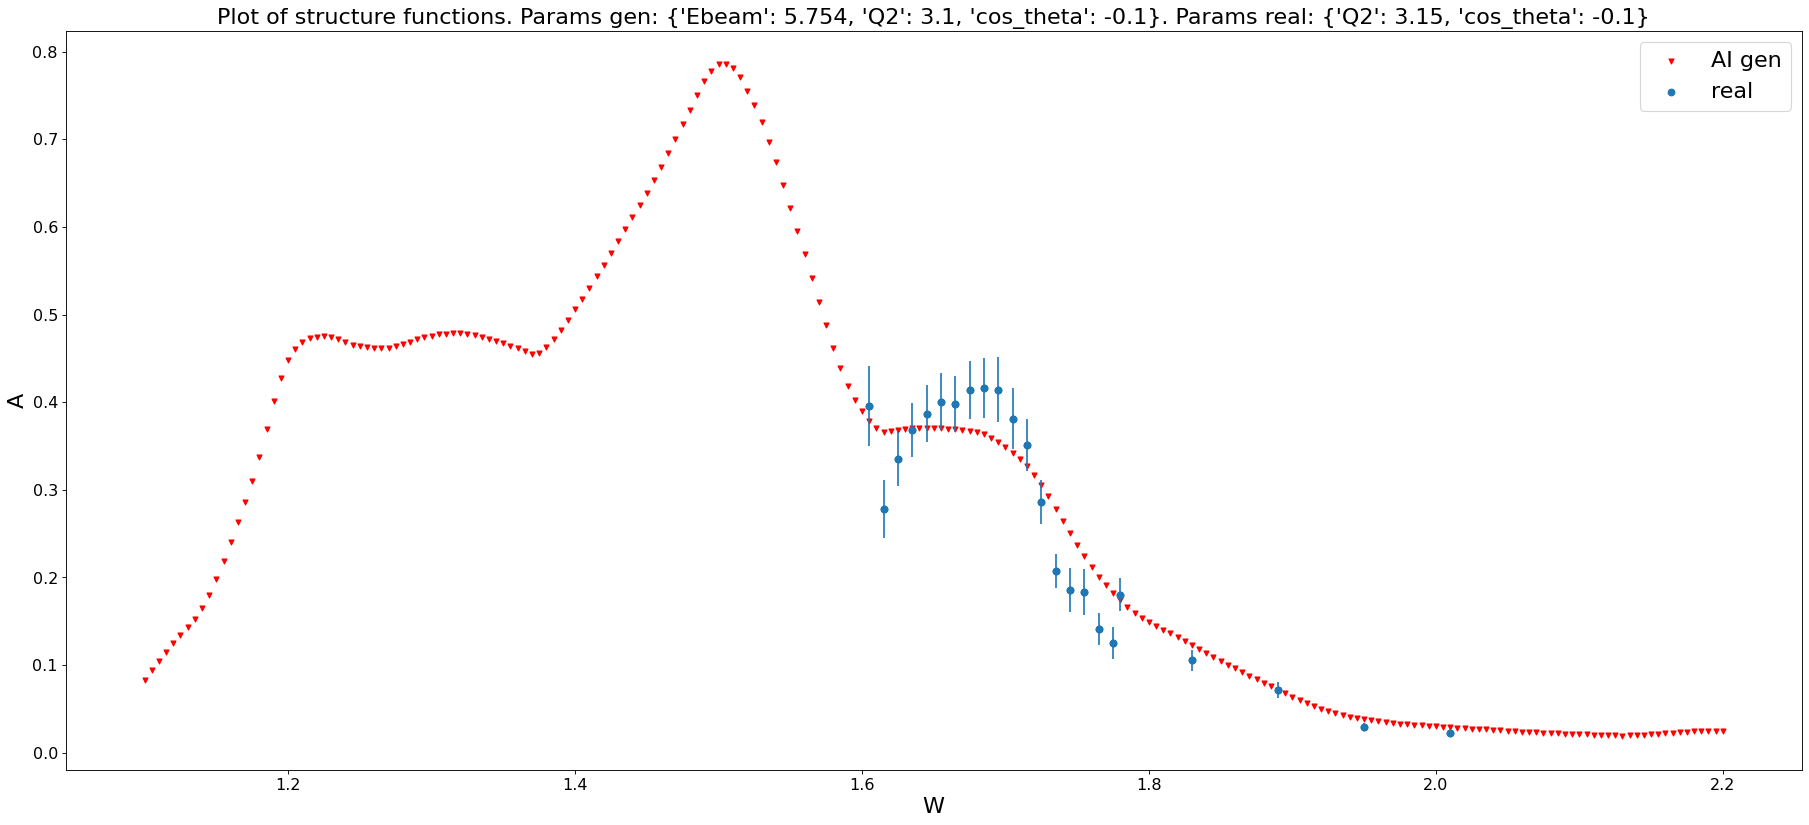

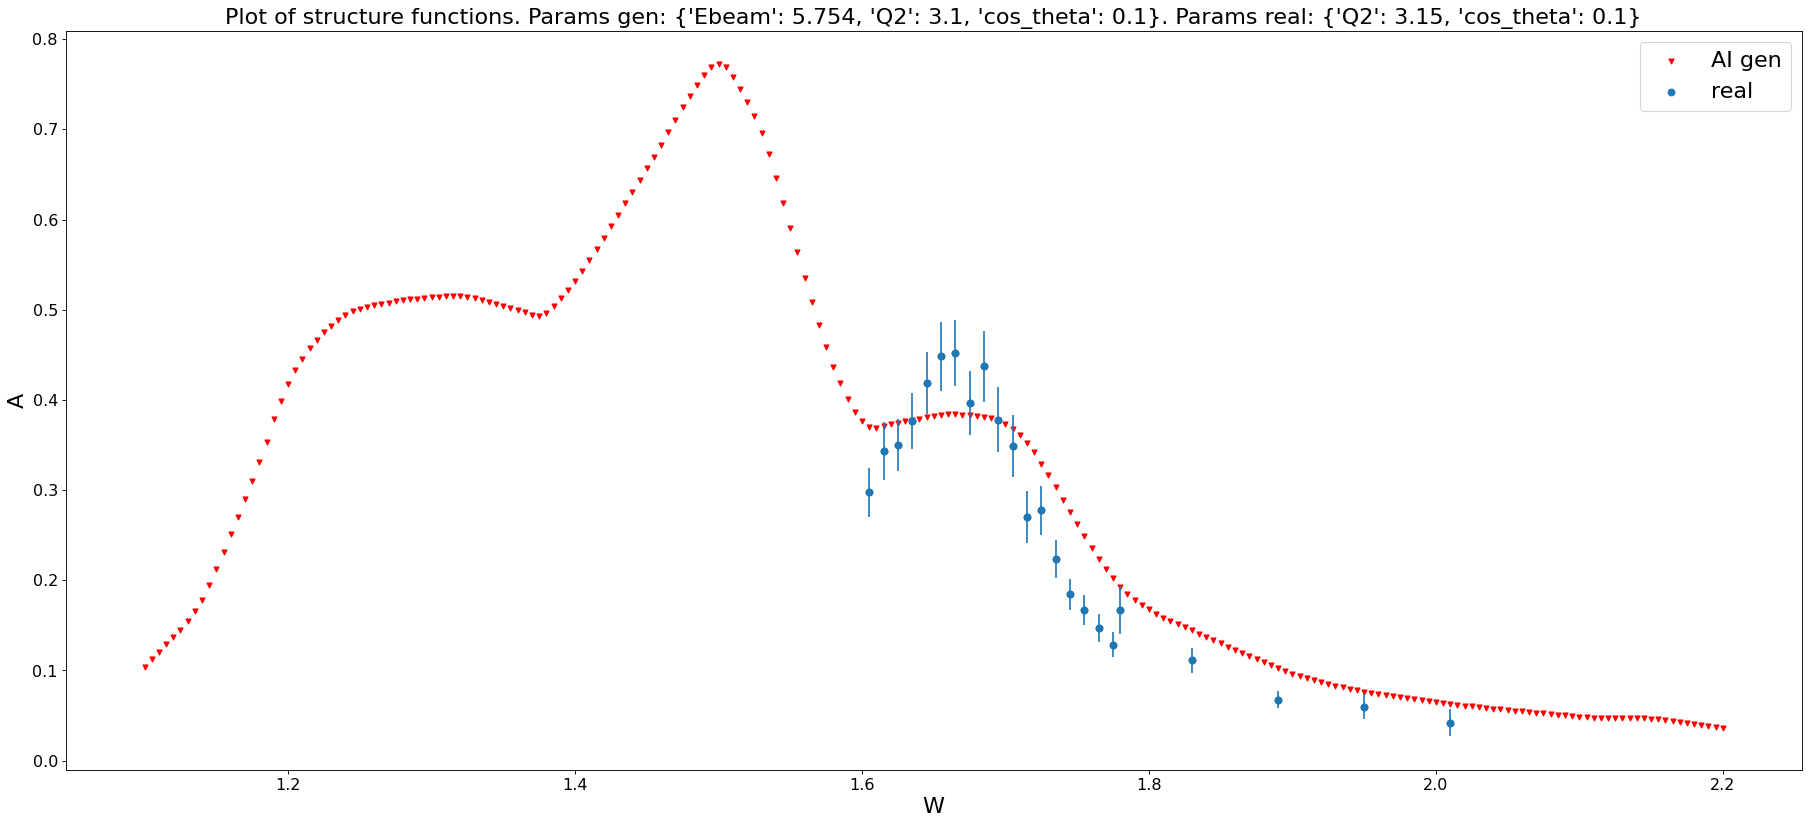

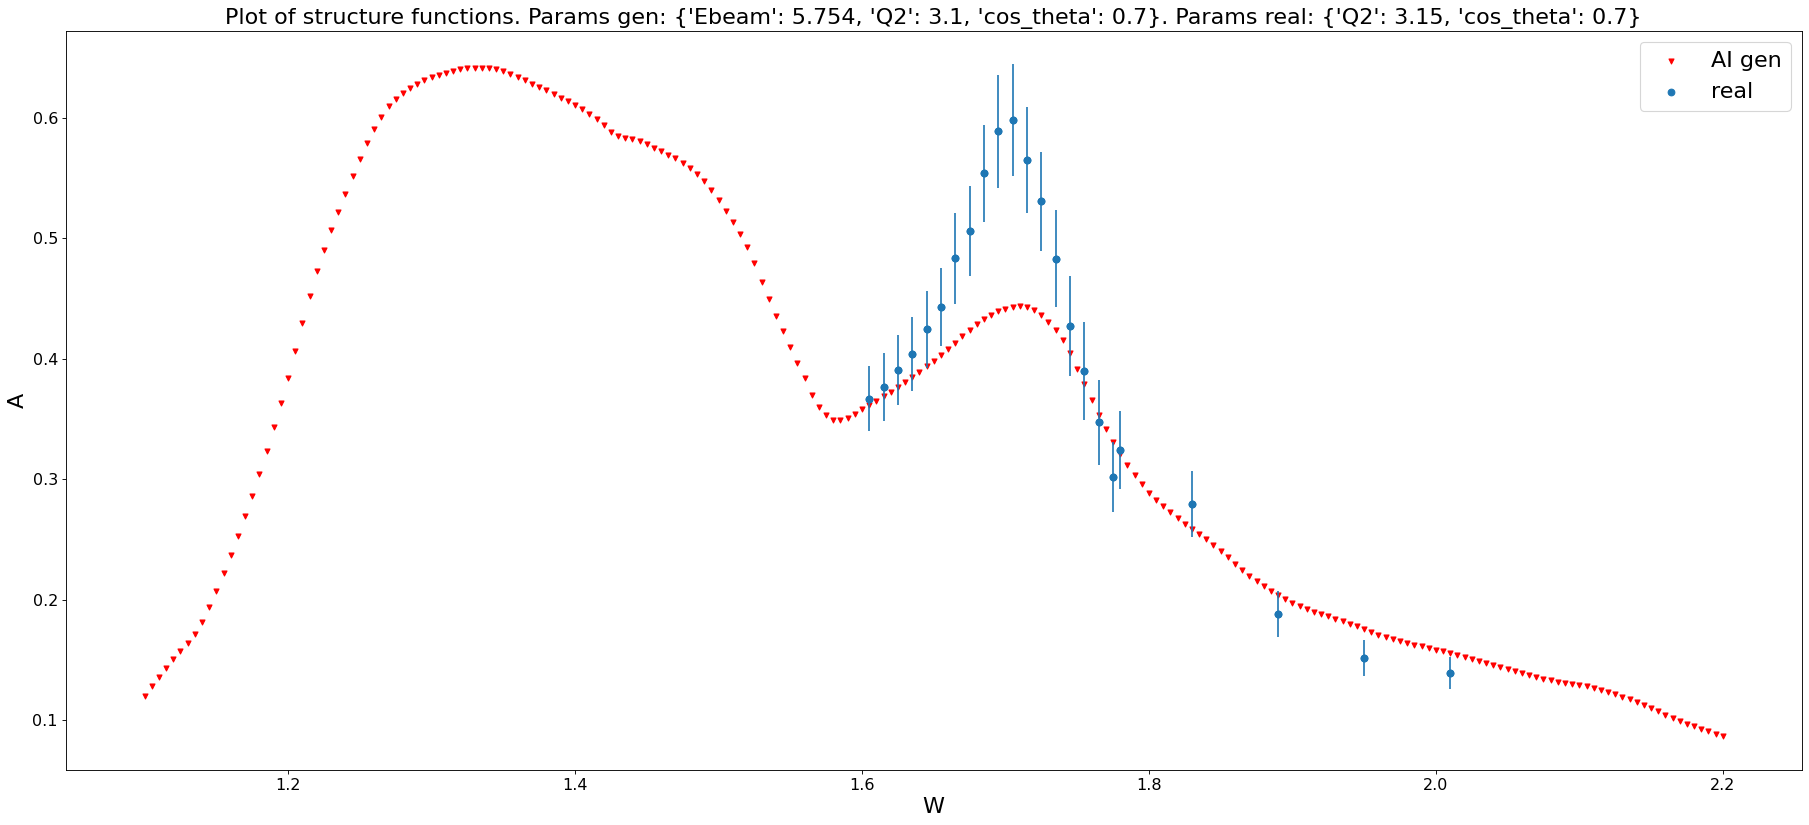

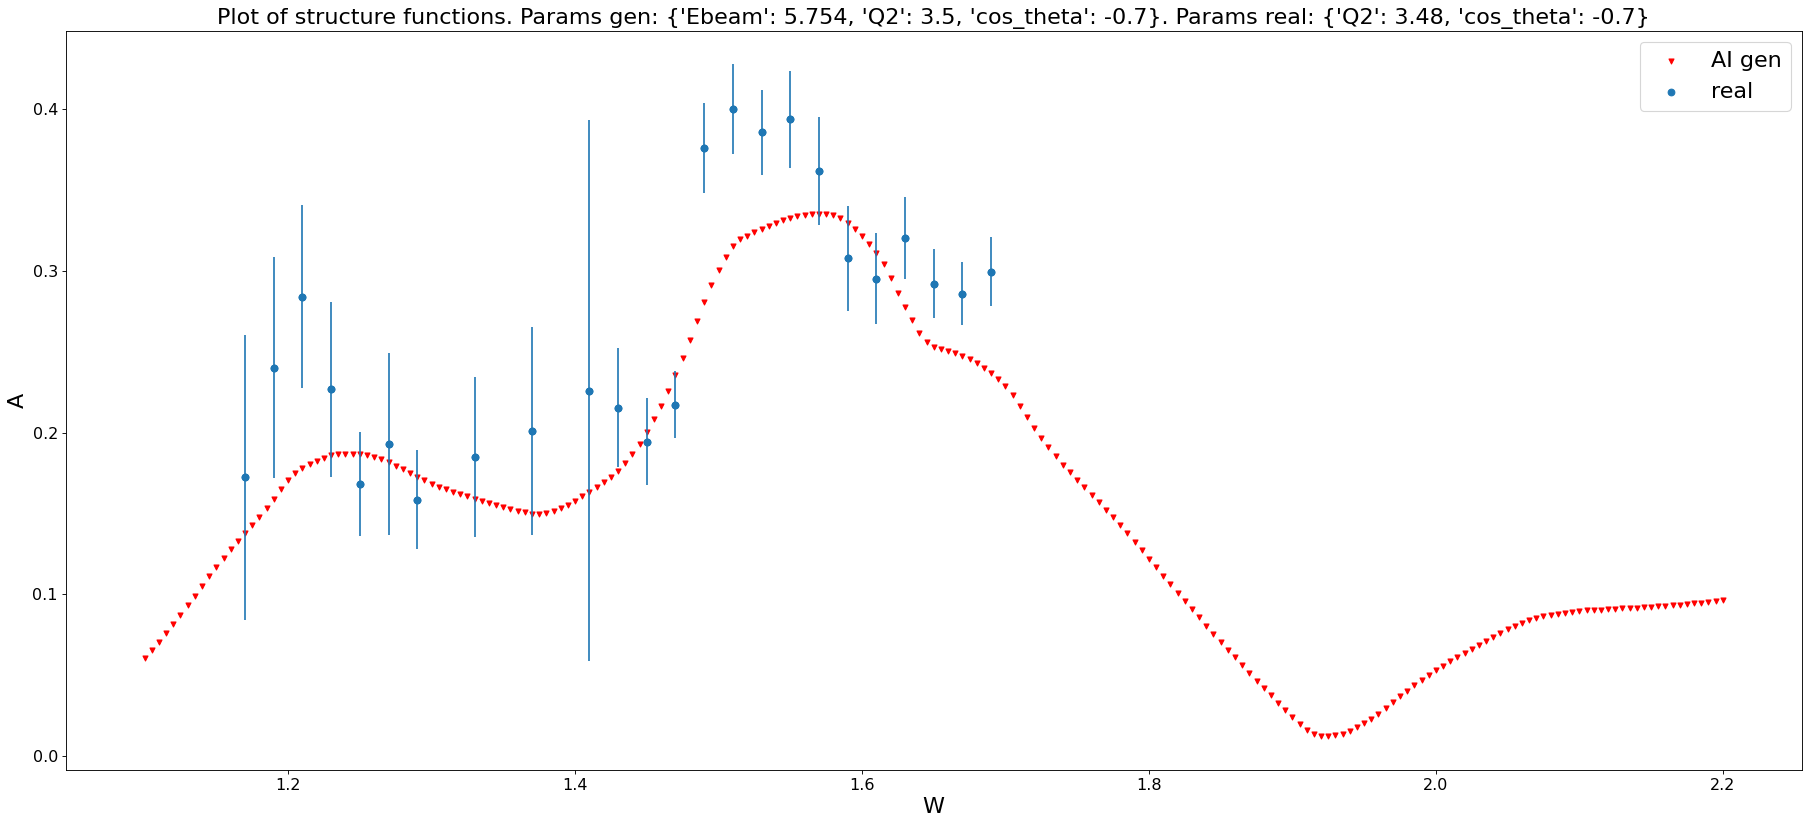

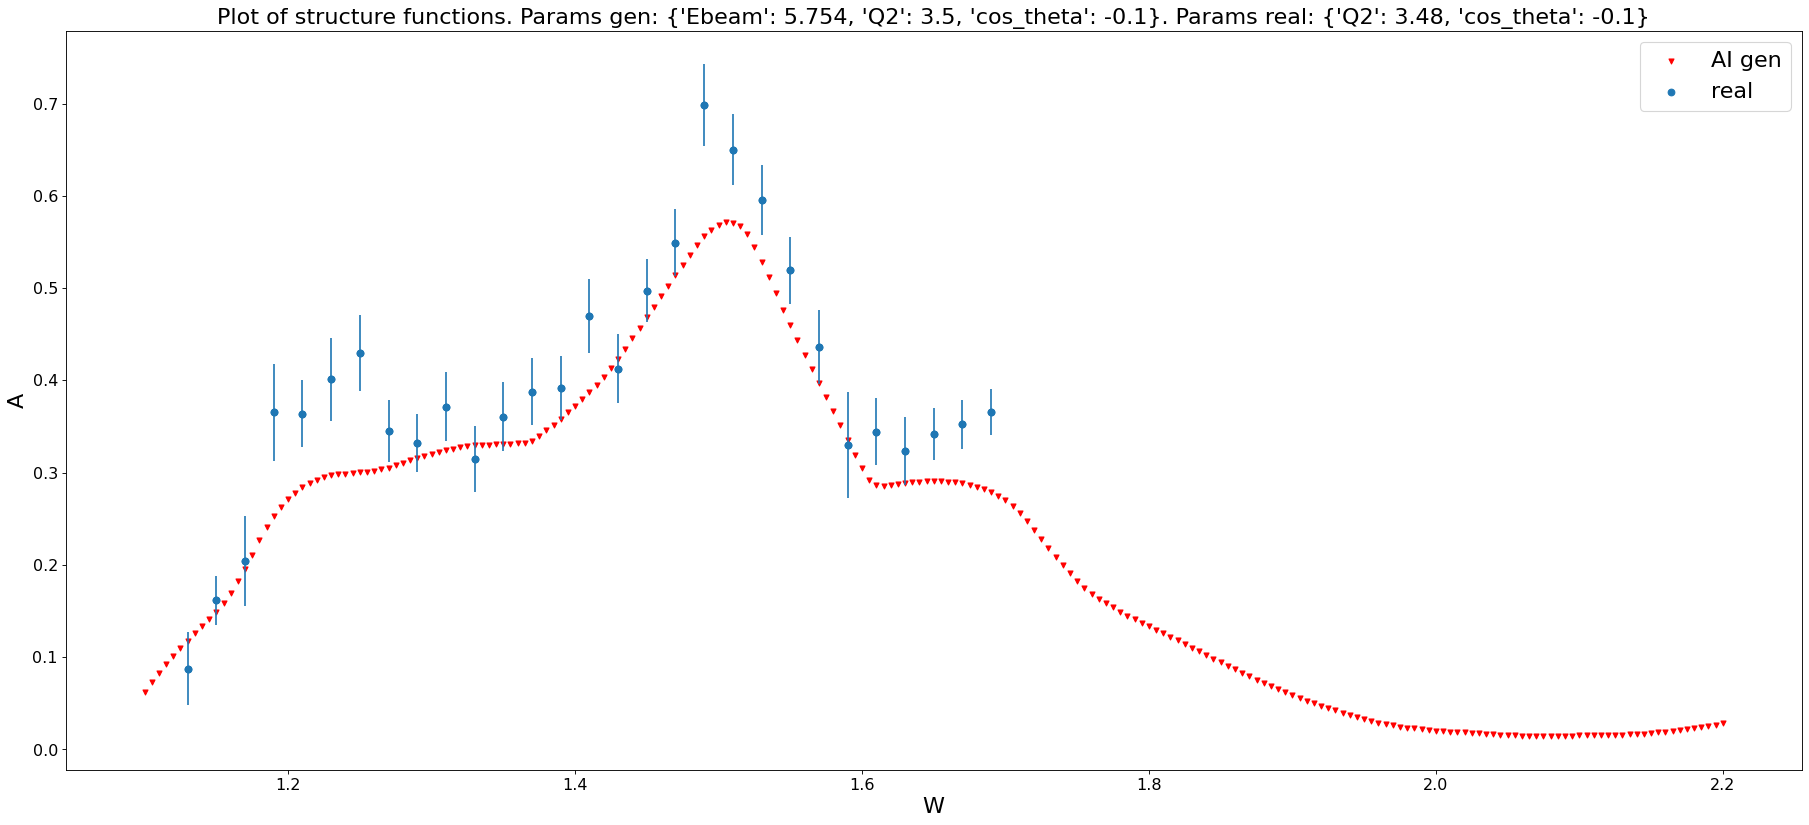

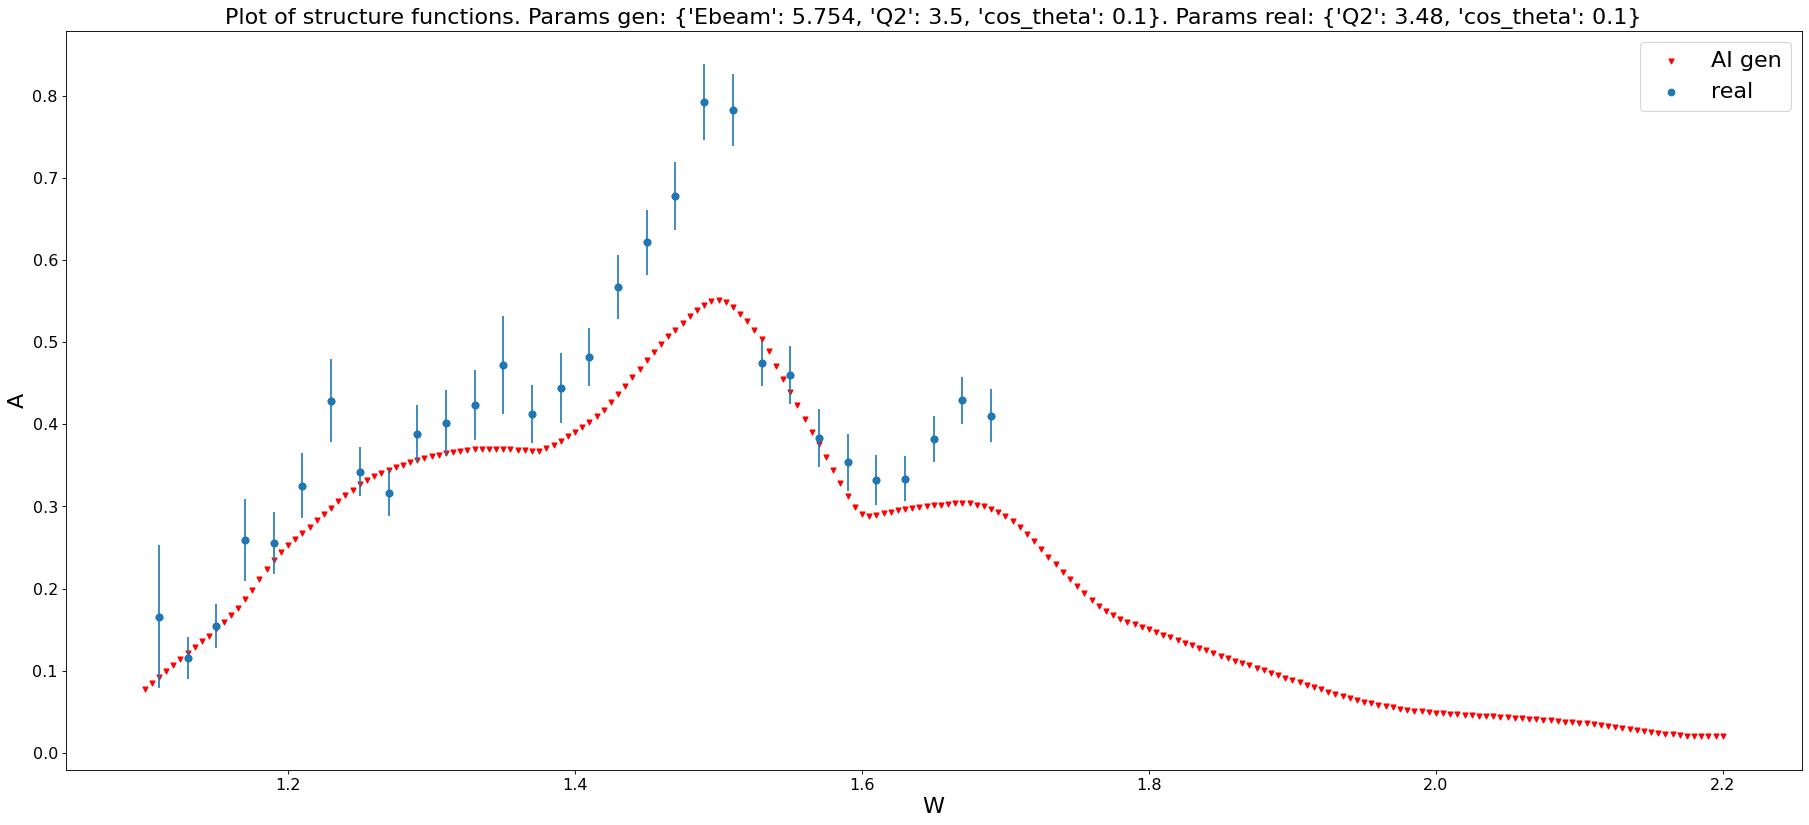

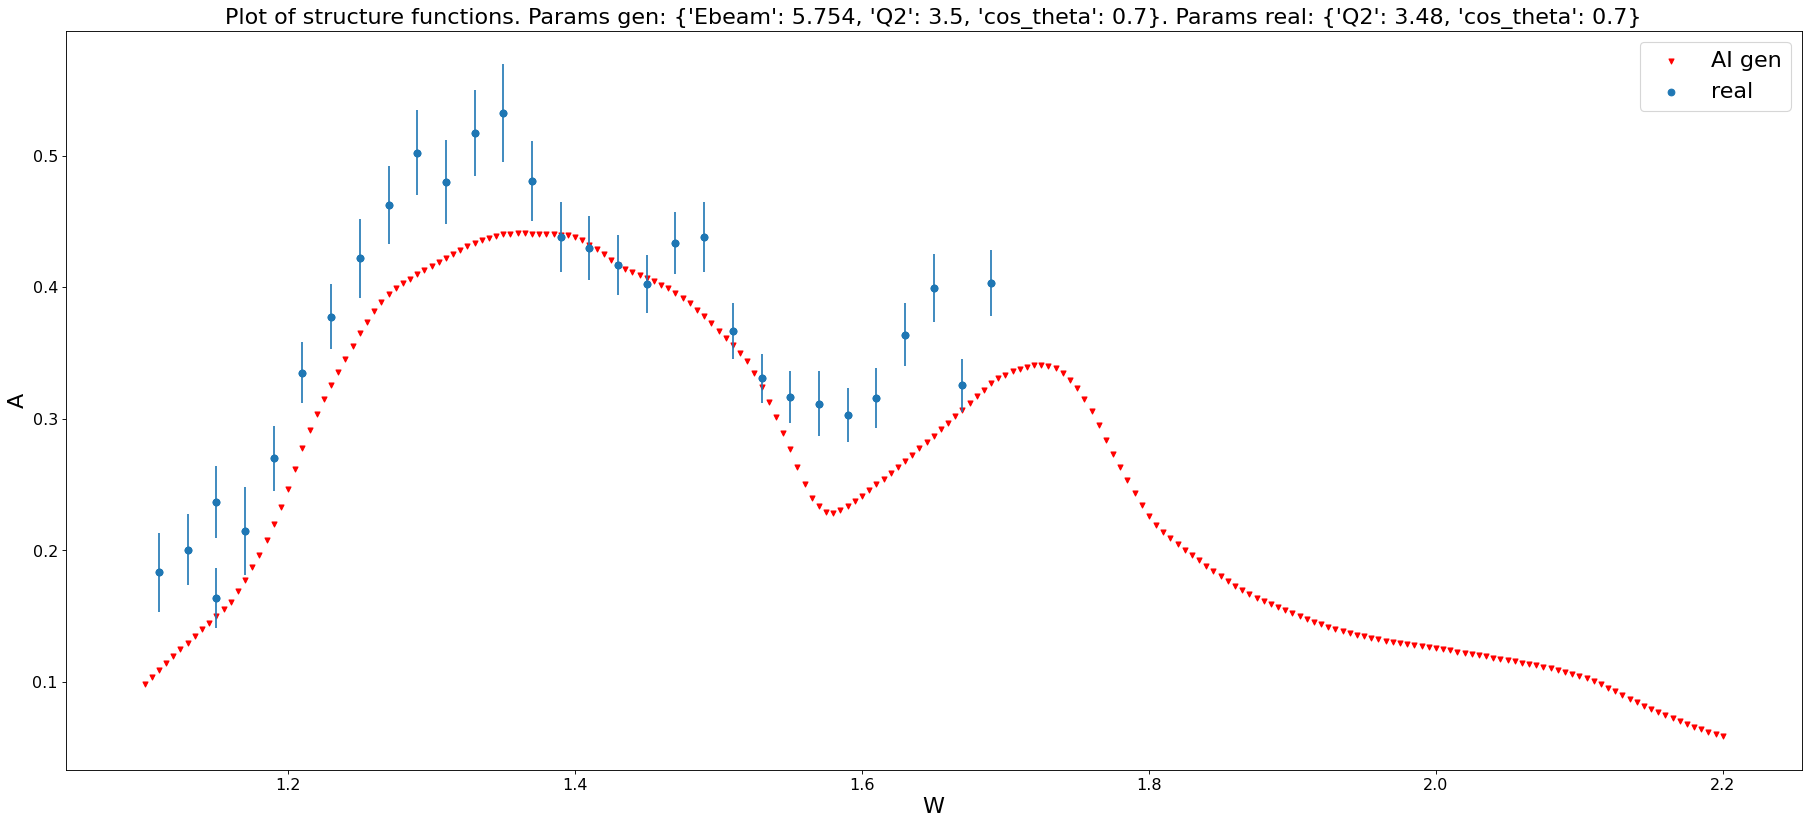

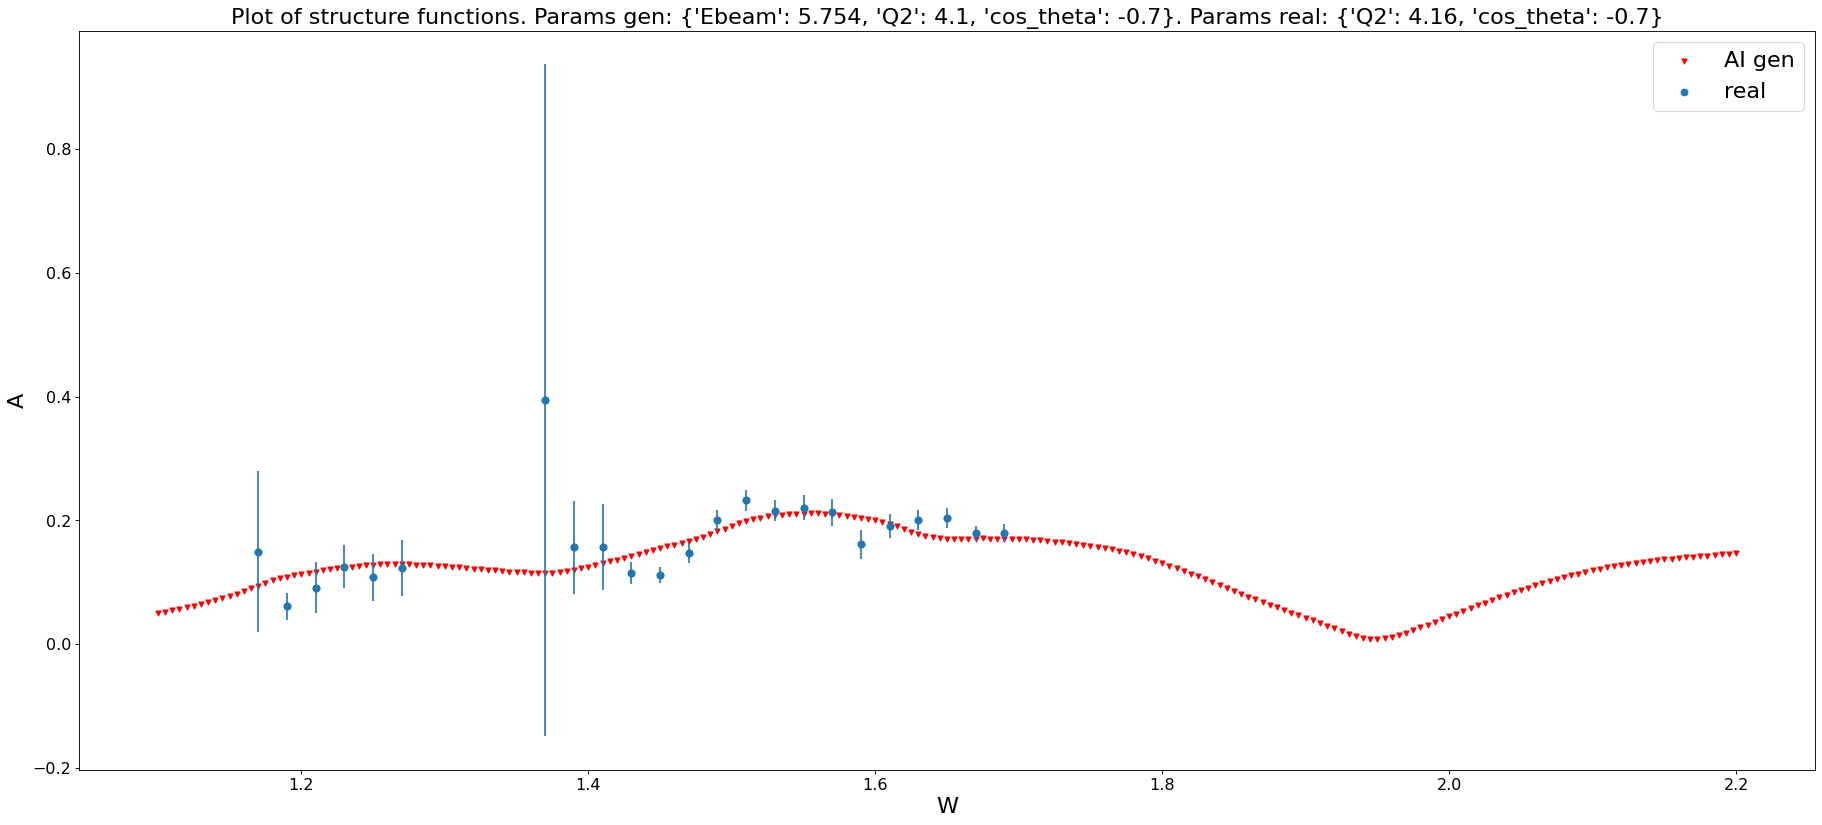

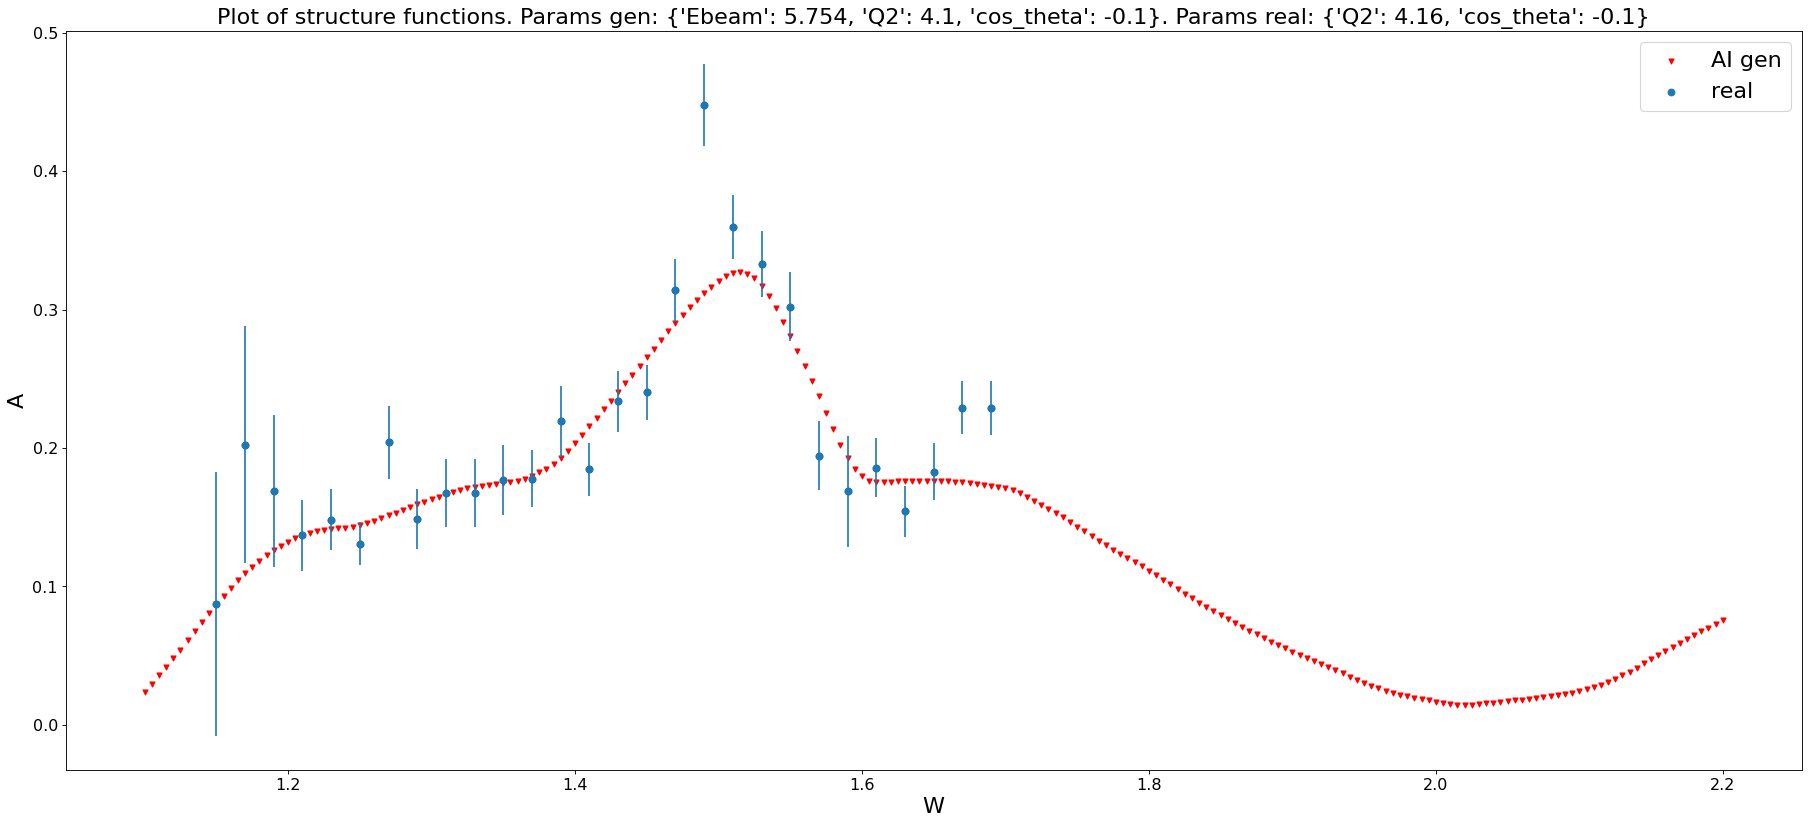

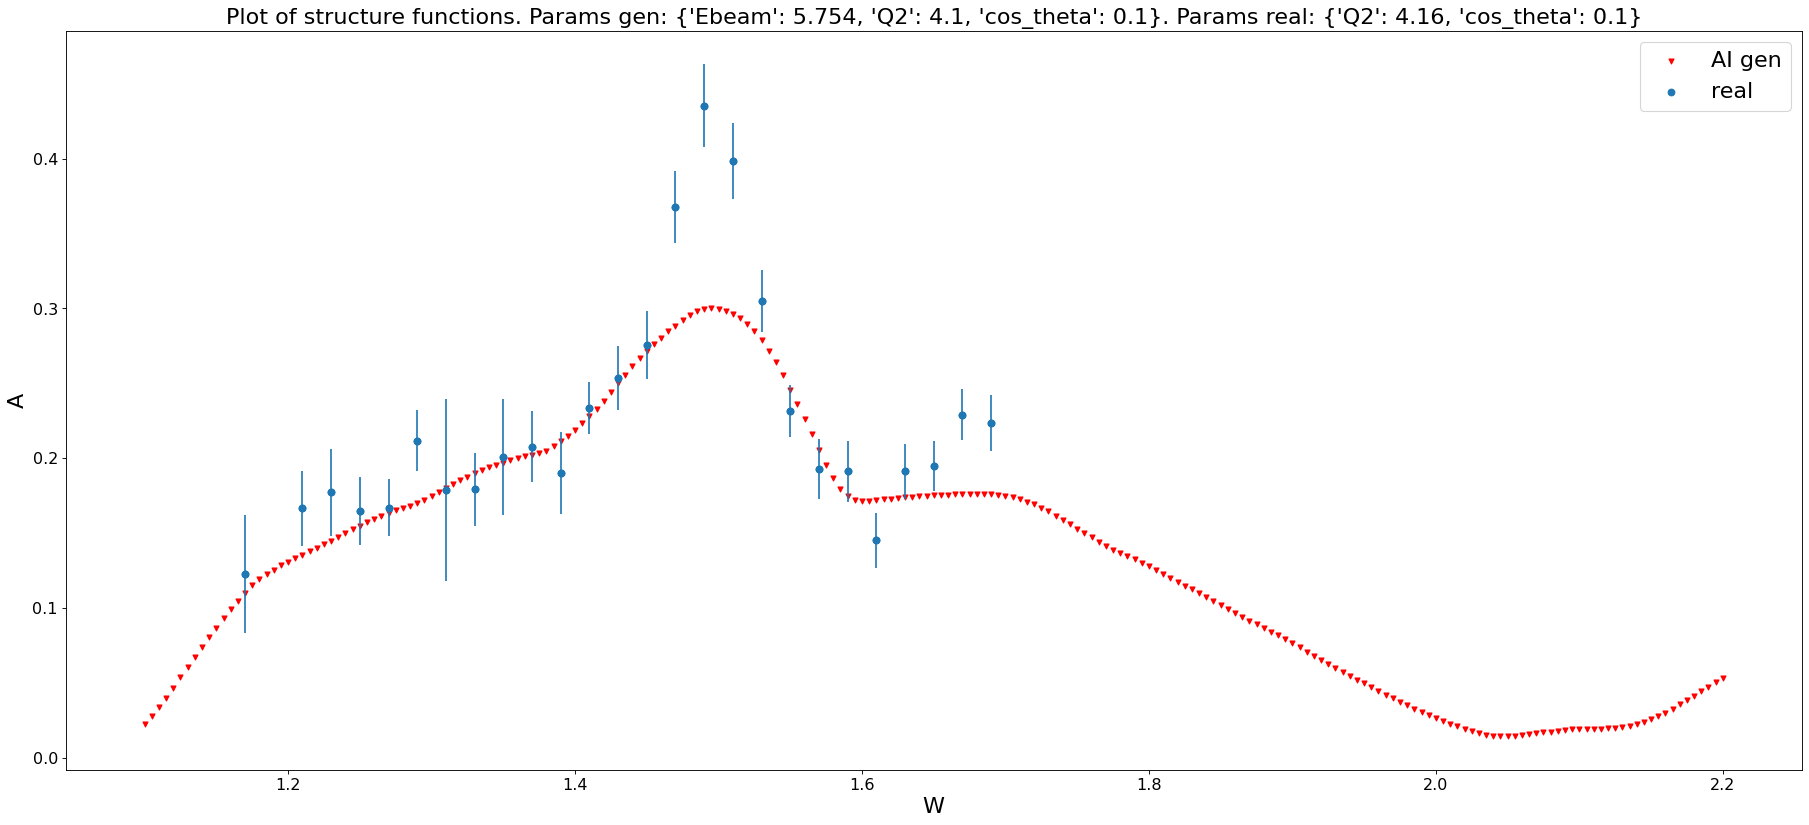

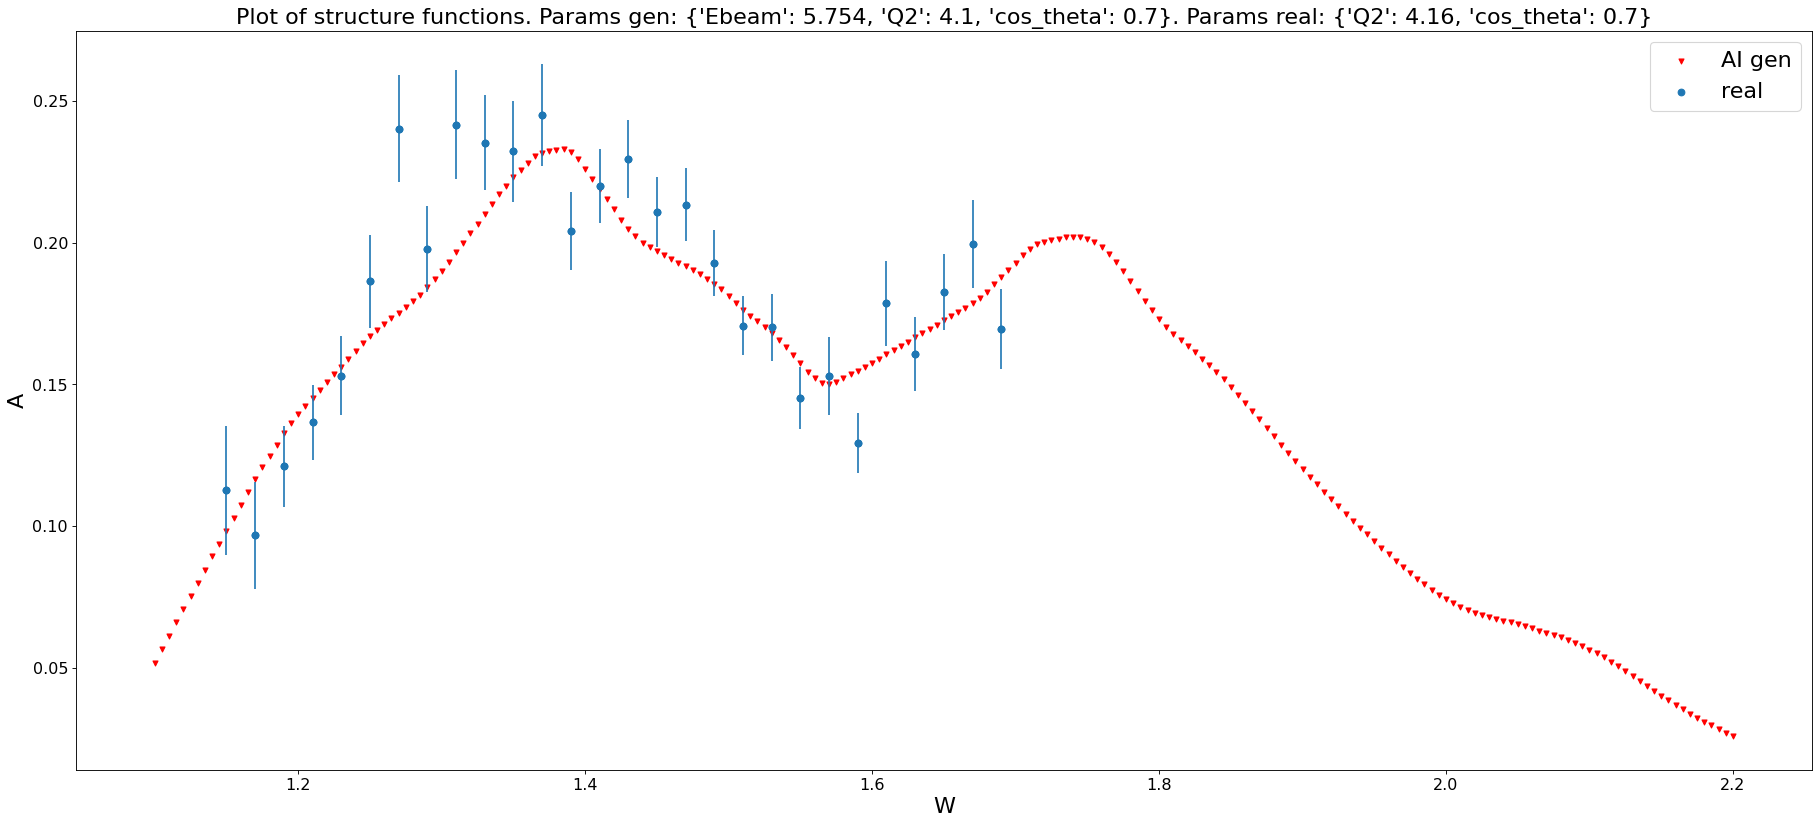

In [39]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (25, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

Ebeam = 5.754
Q2_gen = [1.7, 2.2, 2.4, 2.6, 2.9, 3.1, 3.5, 4.1]
Q2_real = [1.72, 2.2, 2.44, 2.6, 2.91, 3.15, 3.48, 4.16]

cos_theta_gen = cos_theta_real = [-0.7, -0.1, 0.1, 0.7]

for i in range(len(Q2_gen)):
    for j in range(len(cos_theta_gen)):
        params_gen = {'Ebeam' : Ebeam,
                      'Q2' : Q2_gen[i],
                      'cos_theta' : cos_theta_gen[j]}

        params_real = {'Q2' : Q2_real[i],
                       'cos_theta' : cos_theta_real[j]}
        try:
            plot_gen_real_almaz(params_gen, params_real)
        except:
            pass